## Part 4: Data Modelling

## Executive Summary
1. Project Goals
    * Forecast daily bike rental demand on a city-level using multi-linear regression.
    * Determine docks which display similar patterns using network analysis and hierarchical clustering.
    * Further work: Predict future availability of spaces on a docking-station level using classification, requiring assumptions to be made about unbalance (surplus or deficit of bikes) on the network.<br>
<br>
2. Metrics Utilised
    * The main metric used will be: **Root Mean Squared Error (RMSE)** where larger error have larger weight. **R2-score** which is the amount of variance in the target above baseline, explained  by predictors, and **Median Absolute Error (MAE)** where all individual differences have equal weight are also used.<br>
<br>
3. Results
    * Multi linear regression was used initially, along with Lasso, Ridge and ElasticNet regularisation, followed by Support Vector Regressor. ElasticNet (80% Lasso/20% Ridge) performed the best out of the regularisation options for RMSE and R2, but Lasso is a clear winner for MAE.
    * Iterative approach established Gradient Boosting Regressor using GridSearch was the most optimal model choice. Within the decision tree realm this is not a surprise as generally: **Gradient Boosting > Random Forest > Bagging > Single Trees**.
    * This is due to the bias-variance trade-off, and gradient boosting's ability to optimise for variance and bias.
    * Log transformation of the target variable was not utilised due to poor performance. 
    * Network Analysis with a directed graph indicated the network can be classed as one strongly connected component, with a high average node degree of 468. Aggregative clustering indicates more journeys occuring in the north-south (or reverse) direction in central London vs. east-west (or reverse) direction in west London. The River Thames is not acting as barrier in the network. <br>
 <br>
4. Risks/limitations/assumptions
    * There is no record available of the number of bikes available at a station when a hire is made, or how many docks are empty, when a bike is returned. The redistribution of bikes by Serco is also not accounted for.
    * The size of the dataset is too large to visualise as part of network analyis so alternative quantitative techniques have been used such as aggregative clustering.

### Importing packages

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, cosine, jaccard
from scipy.stats import spearmanr
import networkx as nx
import operator
import copy
from yellowbrick.regressor import ResidualsPlot
from eli5.sklearn import PermutationImportance
from eli5 import show_prediction
import eli5
from IPython.display import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (8, 5)
plt.style.use('seaborn-whitegrid')
sns.set(font_scale=1.2)

### Importing data

In [2]:
X = pd.read_csv('X_full.csv', parse_dates = True, date_parser = '%Y-%m-%d')

In [3]:
X['date'] =  pd.to_datetime(X['date'], format='%Y-%m-%d')
X.set_index('date',inplace=True)

In [4]:
X.head()

cloud_cover description  feels_like  humidity  max_temp  min_temp  \
date                                                                            
2012-01-04           34      cloudy           2        81         8         3   
2012-01-05           17       sunny           3        79         9         6   
2012-01-06            8       sunny           3        83         6         2   
2012-01-07           21       sunny           4        75         9         5   
2012-01-08           30      cloudy           4        84         8         3   

            precipitation  sun_hours  temperature  total_snow       ...        \
date                                                                ...         
2012-01-04            0.0        2.9            7         0.0       ...         
2012-01-05            0.0        2.9            8         0.0       ...         
2012-01-06            0.0        2.9            6         0.0       ...         
2012-01-07            0.0        2.9            8         0.0       ...         
2012-01-08            0.0        2.9            7         0.0       ...         

            wind_speed  public_holiday  business_day  school_holiday  weekend  \
date                                                                            
2012-01-04          18               0             1               0        0   
2012-01-05          24               0             1               0        0   
2012-01-06          10               0             1               0        0   
2012-01-07          19               0             0               0        1   
2012-01-08          11               0             0               0        1   

            tube_strike  total_docks  day_week  month  total_journeys  
date                                                                   
2012-01-04            0         9859         2      1           13936  
2012-01-05            0         9886         3      1           14191  
2012-01-06            0         9886         4      1           17713  
2012-01-07            0        10144         5      1           12556  
2012-01-08            0        10144         6      1           10487  

[5 rows x 23 columns]

### Preparation for modelling

#### Drop Variables
`max_temp`, `temperature`, `wind_speed` and `wind_chill` will be ignored in the modelling process due to their multicollinearity with other independent variables.

In [5]:
 X.drop(['max_temp', 'temperature', 'wind_speed', 'wind_chill'], inplace = True, axis = 1)

#### Dummy Variables
* Categorical variables have no natural order (as opposed to ordinal variables where the categories have an order e.g. level of education). Dummy variables will be created for day of week, month and description. 
* With `pd.get_dummies`, using `drop_first = True` to avoid perfect collinearity, this returns n-1 for each categorical column that gets encoded, new columns are prefixed with 'weather', 'month' or 'day' and the original input column is removed.
* The dataframe is checked for any remaining variables which are of type object. The dataframe now only contains int64, uint8 and float64 types.

In [6]:
X = pd.get_dummies(data=X, columns=['description'], prefix = 'weather', drop_first = True)

In [7]:
X = pd.get_dummies(data=X, columns=['month'], prefix = 'month', drop_first = True)

In [8]:
X = pd.get_dummies(data=X, columns=['day_week'], prefix = 'day', drop_first = True)

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2148 entries, 2012-01-04 to 2017-11-20
Data columns (total 40 columns):
cloud_cover               2148 non-null int64
feels_like                2148 non-null int64
humidity                  2148 non-null int64
min_temp                  2148 non-null int64
precipitation             2148 non-null float64
sun_hours                 2148 non-null float64
total_snow                2148 non-null float64
wind_dir_deg              2148 non-null int64
wind_gust                 2148 non-null int64
public_holiday            2148 non-null int64
business_day              2148 non-null int64
school_holiday            2148 non-null int64
weekend                   2148 non-null int64
tube_strike               2148 non-null int64
total_docks               2148 non-null int64
total_journeys            2148 non-null int64
weather_fog               2148 non-null uint8
weather_light_rain        2148 non-null uint8
weather_light_snow        2148 non-null u

#### Setting up target variable
* Remove target variable from dataframe and set to y variable.


In [10]:
y = X.pop('total_journeys')

In [11]:
print 'Returns an array of length:', len(y.values)

Returns an array of length: 2148


#### Calculate baseline prediction for dataset

In [12]:
print 'Baseline prediction for target:', np.round(y.values.mean()), 'hires per day'

Baseline prediction for target: 26272.0 hires per day


### Multi-Linear Regression
*Why use this algorithm?* There appears to be linear relationships present between the target variable and the predictor variables. It's simple to understand and explain the contributions from different variables.

For multi-linear regression there are the following critical assumptions:
* Y must have an approximately linear relationship with each independent Xi.
* Errors (residuals) ϵi and ϵj must be independent of one another for any i≠j.
* Errors (residuals) follow a normal distribution
* Errors (residuals) should have a roughly consistent pattern, regardless of the value of the Xi predictors. No discernable relationship between the X predictors and the residuals.
* Independent variables Xi and Xj must be independent of one another for any i≠j.


#### Cross Validation
* Cross validation will be carried out using both `train_test_split` and `cross_val_score`. This is to check the model's ability to generalise to new data.
* For `train_test_split`, the most basic type of hold-out validation, a value of 30% is used for the test, with the remaining 70% used for training. The train and test split is based on `random_state` which is the seed using by the random number generator.
* For cross_val_score, in each of the k folds a different model is built with different coefficients depending on the training set of data which is used. This is then applied to the  "validation" set and the output metric applied. A k of 10 will be used.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.3, random_state = 8)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(1503, 39) (1503,)
(645, 39) (645,)


#### Standardisation 
Scale predictor variables to handle any disparities present in the units and precent steps on different axis from varying widely. Standardisation allows direct comparison of the magnitude of impact between different predictors as beta coefficients have similar magnitudes. The fit and transform is carried out on the training set, whereas only the transform is applied to the test set.

In [14]:
ss = StandardScaler()
Xs = pd.DataFrame(ss.fit_transform(X_train),columns=X_train.columns)

In [15]:
Xt = pd.DataFrame(ss.transform(X_test),columns=X_test.columns)

In [16]:
Xtot = pd.DataFrame(ss.fit_transform(X), columns=X.columns)

#### Fit and Score Model - Train/Test Split

Fit, predict and score an sklearn LinearRegression model. A function is defined to allow rapid plotting of the true y and predicted y values vs a perfect model and the baseline.

In [132]:
lm = LinearRegression()
model1 = lm.fit(Xs, y_train)
R2 = model1.score(Xt, y_test)
print "R2 Score:", R2
yhat = model1.predict(Xt)
RMSE = np.sqrt(mean_squared_error(yhat, y_test))
print 'RMSE:', RMSE
MAE = median_absolute_error(y_test, yhat)
print 'MAE:', MAE

R2 Score: 0.734993337324
RMSE: 4579.6979565
MAE: 2507.94439274


In [18]:
def plot_y_yhat(y_test, yhat):
     
    plt.figure(figsize=(10,7))
    plt.scatter(y_test, yhat, color='darkgoldenrod', s=30, label='yhat - true y')

    max_val = np.max(y_test)
    min_val = np.min(y_test)

    plt.plot([min_val, max_val], [min_val, max_val], color='darkgreen',
            linewidth=4.0, alpha=0.7, label='perfect model')
    
    plt.axhline(y=y_train.mean(), linewidth = 4, label = 'baseline prediction')

    plt.xlabel('True y', fontsize=16)
    plt.ylabel('y predictions', fontsize=16)

    plt.legend(loc='upper left')

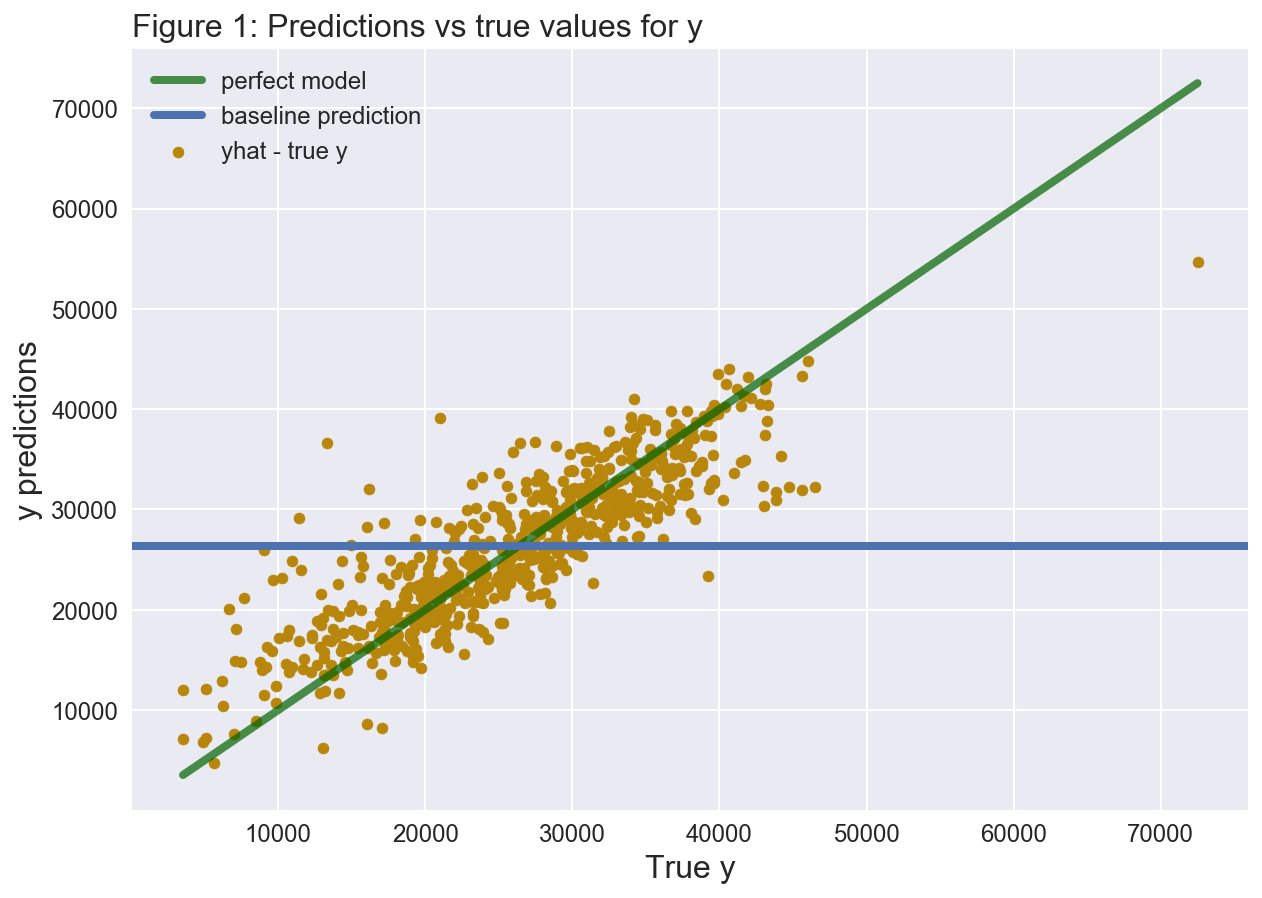

In [19]:
plot_y_yhat(y_test, yhat)
plt.title('Figure 1: Predictions vs true values for y', loc = 'left', fontsize = 16)
plt.show()
# This is doing a reasonable job on the significant outlier at c.72,000.
           

In [20]:
model1_coeff = pd.DataFrame({'variable': Xs.columns, 'coeff' : model1.coef_, 'abs_coeff': np.abs(model1.coef_)})

In [21]:
# These seem a little odd as 2 of the top 3 positive coefficients are day_5 (Saturday) and day_6 (Sunday) 
# These days should be the inverse of business_day which ranks at 5, and have the same sign as weekend which is negative!
model1_coeff.sort_values('abs_coeff', ascending = False).head(10)

abs_coeff        coeff      variable
37  3451.271187  3451.271187         day_5
1   3360.068439  3360.068439    feels_like
38  3224.379704  3224.379704         day_6
12  3180.426385 -3180.426385       weekend
10  3073.468490  3073.468490  business_day
14  1736.705691  1736.705691   total_docks
27  1389.795233  1389.795233       month_7
28  1369.711280  1369.711280       month_8
5   1331.760026  1331.760026     sun_hours
30  1203.383864  1203.383864      month_10

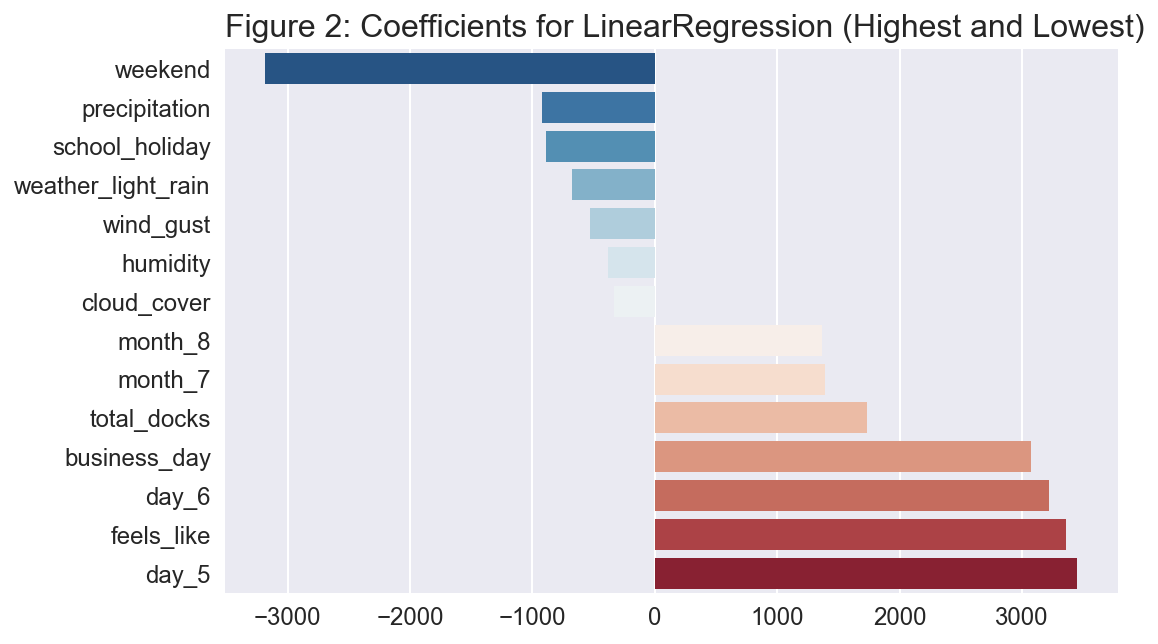

In [22]:
coef = pd.Series(model1.coef_, index = Xs.columns)
sort_coef = pd.concat([coef.sort_values().head(7),
                      coef.sort_values().tail(7)])

sns.barplot(y = sort_coef.index, x = sort_coef.values, palette = "RdBu_r")
plt.title("Figure 2: Coefficients for LinearRegression (Highest and Lowest)", loc = 'left', fontsize = 16)
plt.show()

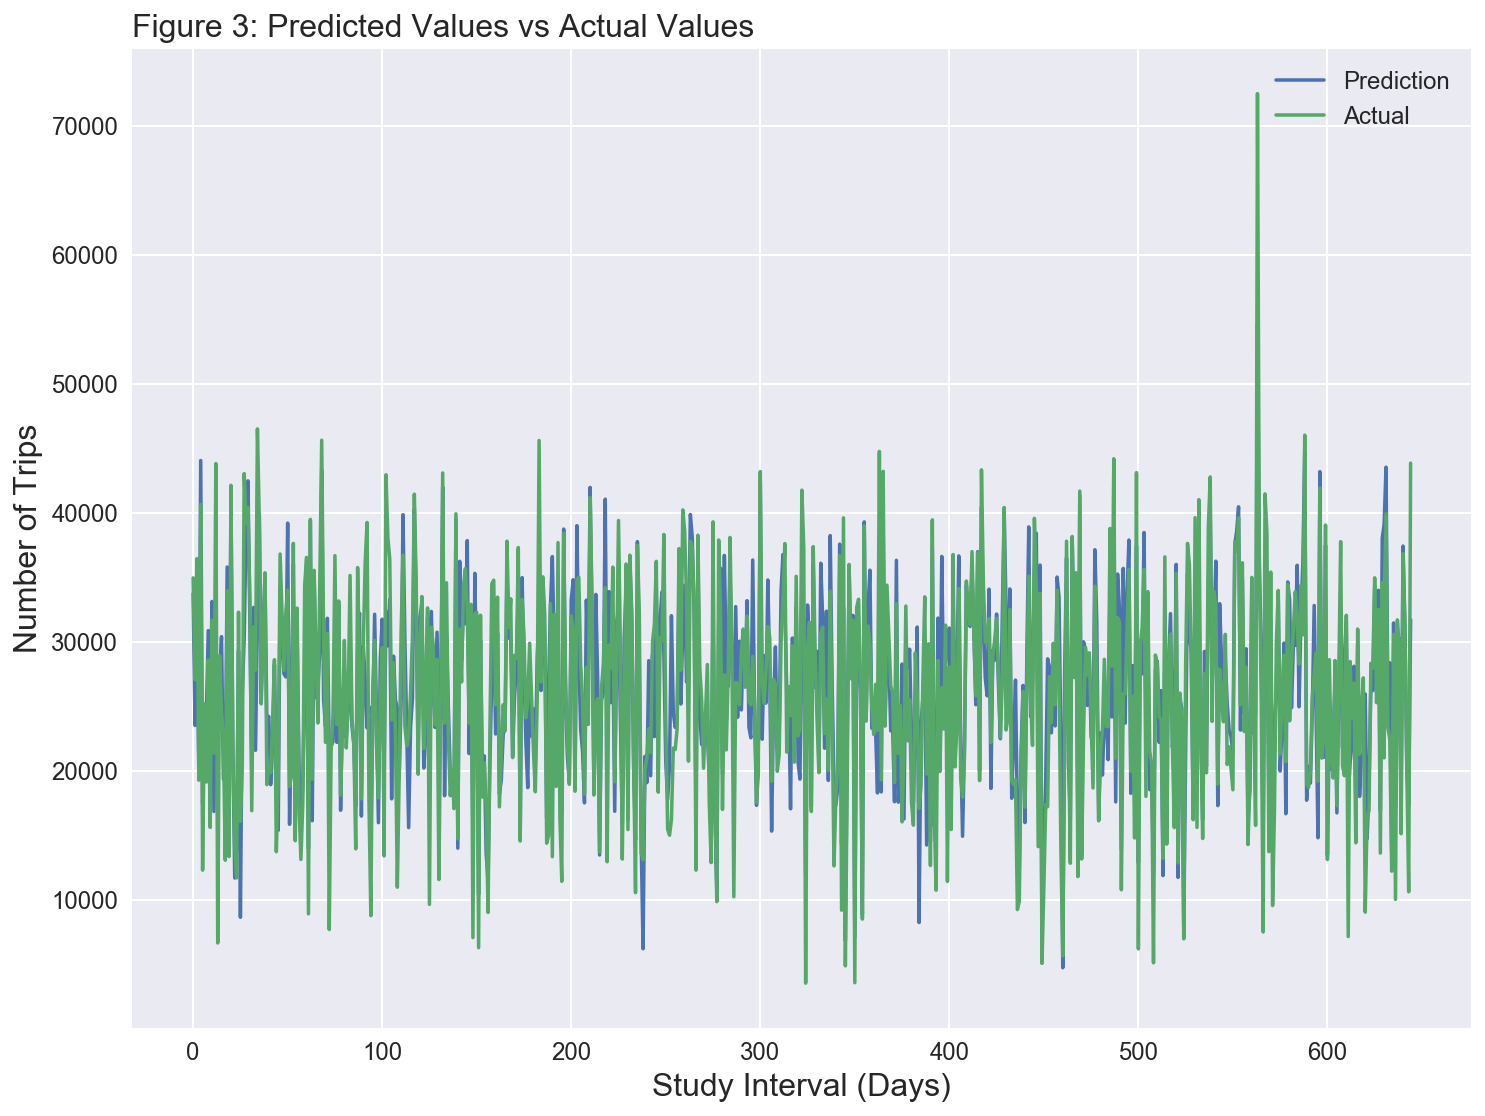

In [23]:
fs = 16
plt.figure(figsize=(12,9))
plt.plot(yhat)
plt.plot(y_test)
plt.legend(['Prediction', 'Actual'])
plt.ylabel("Number of Trips", fontsize = fs)
plt.xlabel("Study Interval (Days)", fontsize = fs)
plt.title("Figure 3: Predicted Values vs Actual Values", fontsize = fs, loc = 'left')
plt.show()

The residuals plot from YellowBrick shows the error against the predicted value for the training data and the testing data. It allows us to look for heteroskedasticity in the model; e.g. regions in the target where the error is greatest. The residuals appear to be relatively randomly distibuted, though the models appears to have a tendency to underestimate the highest values and overestimate the lowest values.

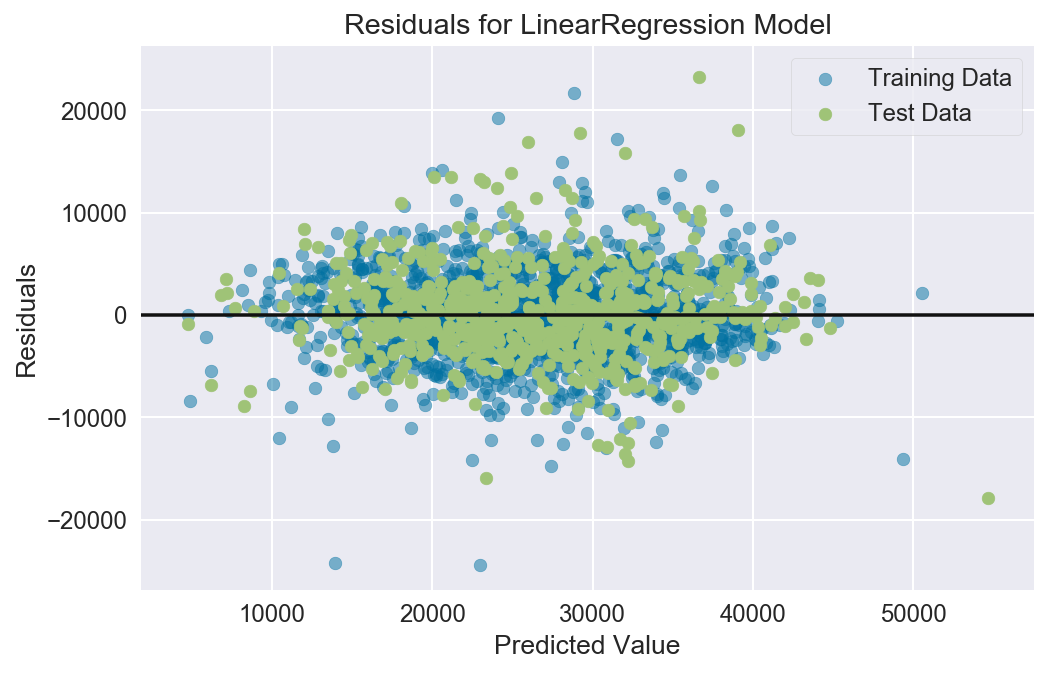

In [140]:
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(Xs, y_train)
visualizer.score(Xt, y_test)
visualizer.poof()

#### Fit and score model - Cross validation score
There is a risk of overfitting using the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model. To solve this problem, another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set. In cross validation, a test set should still be held out for final evaluation, but no separate validation set is needed.

Use the same `lm` model which was instantiated in the section above to carry out cross validation with a fold of 5. Three scorers are set up using Root Mean Squared Error, Median Absolute Error and R2-score. RMSE is more desirable when large errors need to be avoided, MAE gives the absolute error so does not penalise larger errors more.

In [25]:
def RMSE_CV(model):
    RMSE = np.sqrt(-cross_val_score(model, Xs, y_train, scoring="neg_mean_squared_error", cv = 5))
    return np.round(np.mean(RMSE),2)
print RMSE_CV(lm)

4443.81


In [26]:
def MAE_CV(model):
    scores = cross_val_score(model, Xs, y_train, cv=5, n_jobs=1, scoring = 'neg_median_absolute_error')
    return np.round((np.median(scores) * -1),0)
print MAE_CV(lm)

2783.0


In [27]:
def R2_CV(model):
    R2 = cross_val_score(model, Xs, y_train, scoring="r2", cv = 5)
    return np.round(np.mean(R2),4)
print R2_CV(lm)

0.7301


In [28]:
# Set up lists to keep track of cross validation scores. RMSE will be used as the main metric 
# for comparison throughout.
method = []
RMSE_metric = []
method.append('LinearRegressionCV')
RMSE_metric.append(RMSE_CV(lm))

In [29]:
# If not specified, uses signature scorer associated with model, r2-score in this case.
scores = cross_val_score(lm, Xs, y_train, cv=5)
predictions = cross_val_predict(lm, Xt, y_test, cv=5)
print np.mean(scores)

0.730106514816


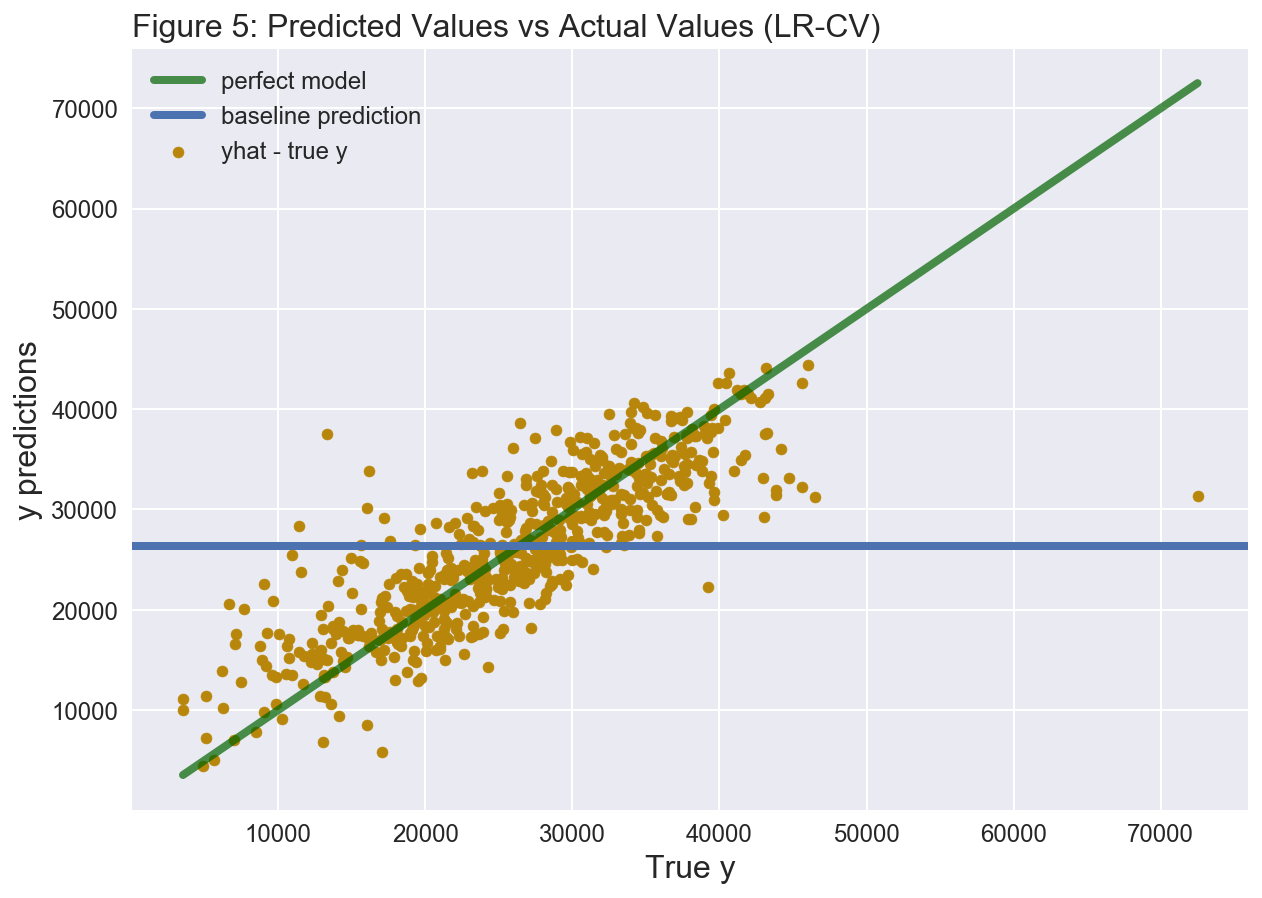

In [30]:
plot_y_yhat(y_test, predictions)
plt.title("Figure 5: Predicted Values vs Actual Values (LR-CV)", fontsize = fs, loc = 'left')
plt.show()
# The outcome from cross validation is not predicting as successfully for the outlier at c.72,000.

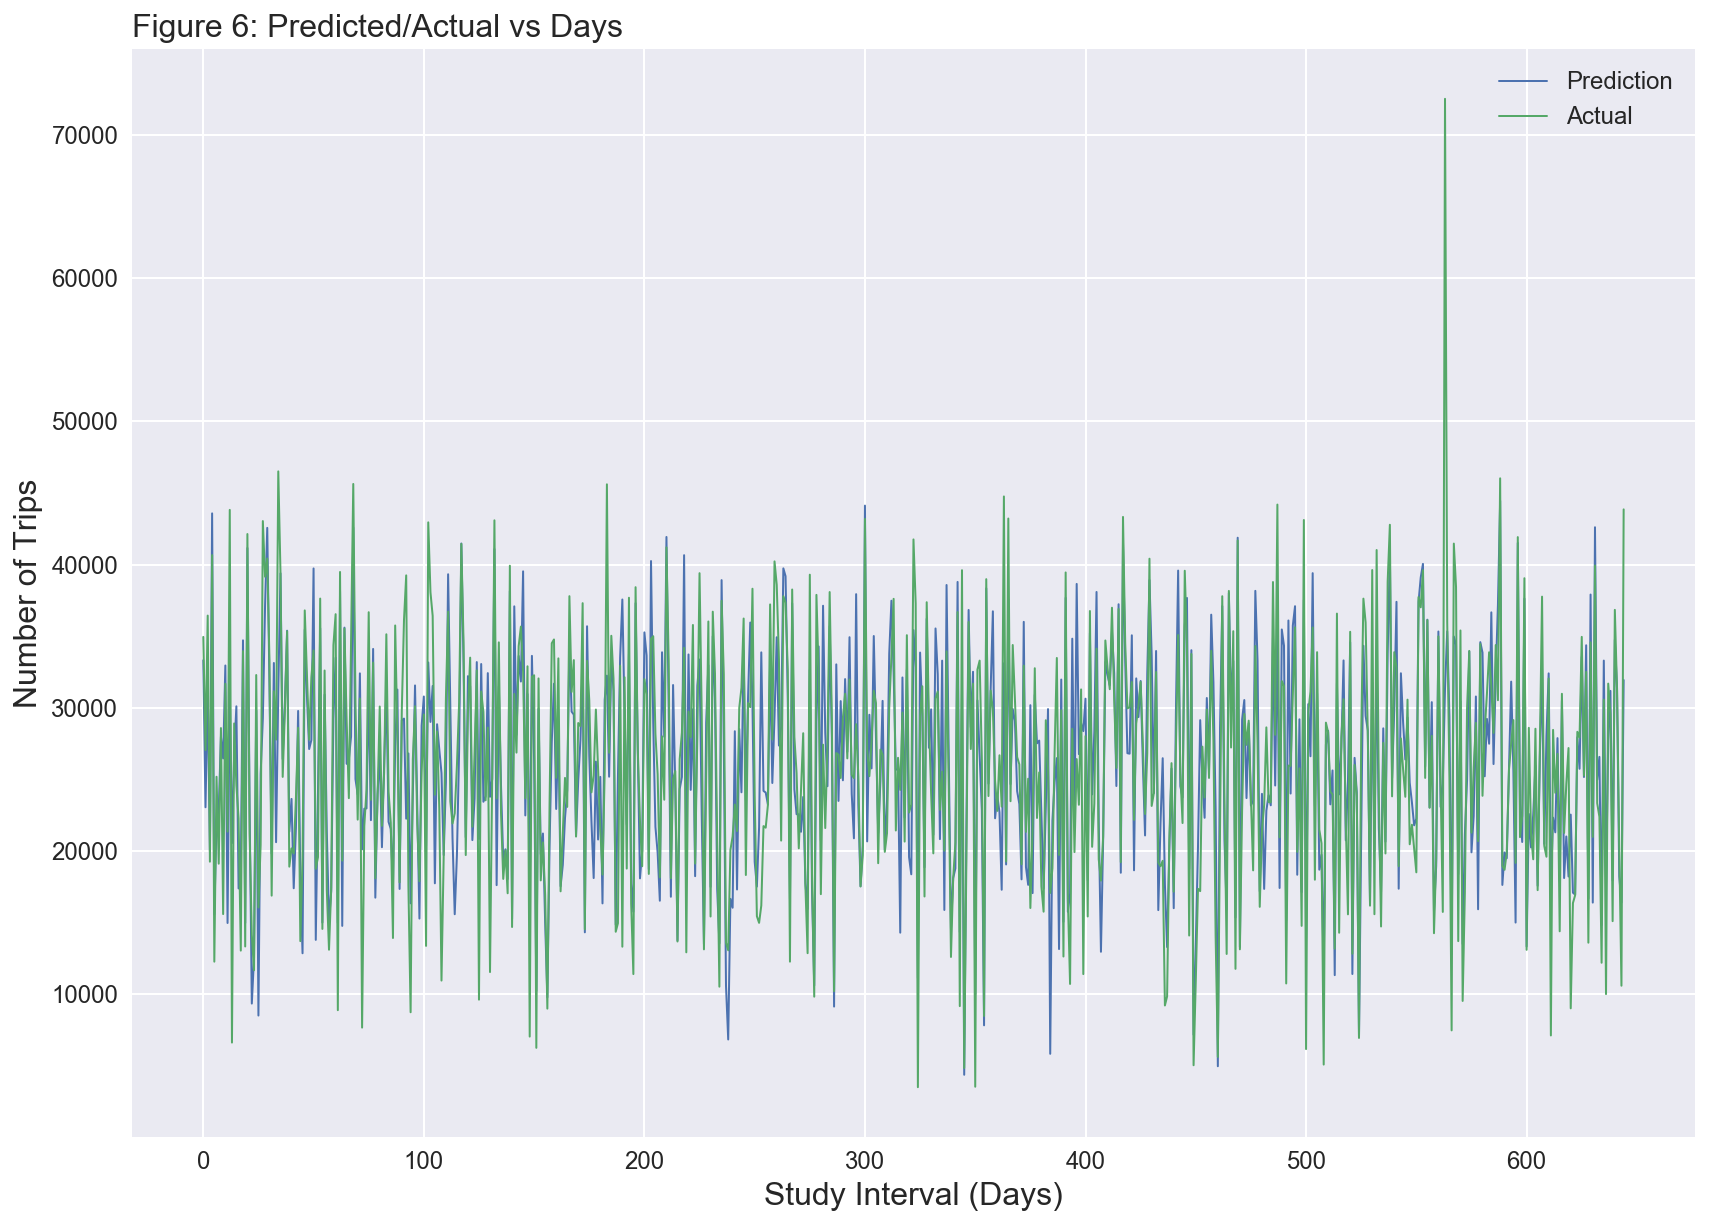

In [31]:
fs = 16
plt.figure(figsize=(14,10))
plt.plot(predictions, linewidth = 1)
plt.plot(np.array(y_test), linewidth = 1)
plt.legend(['Prediction', 'Actual'])
plt.ylabel("Number of Trips", fontsize = fs)
plt.xlabel("Study Interval (Days)", fontsize = fs)
plt.title("Figure 6: Predicted/Actual vs Days", fontsize = fs, loc = 'left')
plt.show()

#### Log Transform Dependent Variable

Errors, as estimated by the residuals, are assumed to be normally distributed. When they are positively skewed taking logs may help. The target variable has a slight postive skew, with a much longer right hand tail so performing a log tranformation will be tested.


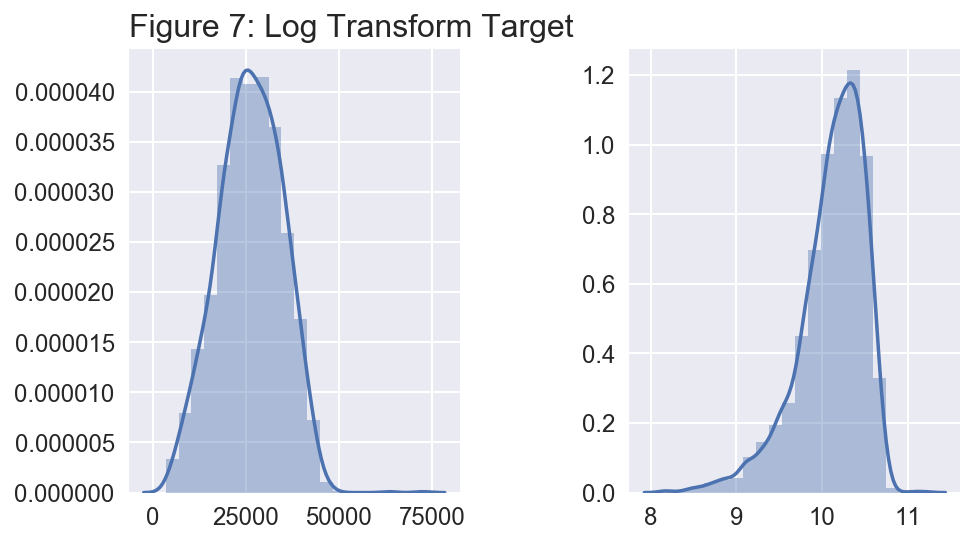

In [32]:
target = np.array(y)
plt.figure(figsize = (7, 4))
plt.subplot(1,2,1)
sns.distplot(target, bins = 20)
plt.title('Figure 7: Log Transform Target', loc = 'left', fontsize = fs)
plt.subplot(1, 2, 2)
sns.distplot(np.log1p(target), bins = 20)
plt.tight_layout()
plt.show()

In [33]:
y_train_l = np.log1p(y_train)
y_test_l = np.log1p(y_test)
y_l = np.log1p(y)
model2 = lm.fit(Xs, y_train_l)
yhat = model2.predict(Xt)

R2 = r2_score(np.exp(yhat), np.exp(y_test_l))
print 'R2:', R2
print 'RMSE:', np.sqrt(mean_squared_error(np.exp(yhat), np.exp(y_test_l)))
print 'MAE:', median_absolute_error(np.exp(yhat), np.exp(y_test_l))


R2: 0.673430457637
RMSE: 4834.88926753
MAE: 3077.3484709


#### Regularisation
The goal of regularisation is to structurally prevent overfitting by imposing a penalty on the coefficients of the model. The larger the lambda, the lower the coefficients required to keep loss low. Lasso, Ridge and ElasticNet will be tested with GridSearch. *Why use GridSearching?* Gridsearching can be used to find the optimal hyperparameters for the model. It gets its name from the fact is searches over a “grid” of parameters, using cross validation internally, to find the optimal set of hyperparameters for the model.
* Ridge regularisation ouputs the most optimal value of alpha as 10. The RMSE score is on a par with cross-validated linear regression. `feels_like`, `total_docks` and `sun_hours` are the highest ranking features with `feels_like` having a coefficient twice as large as the next.
* Lasso regularisation outputs the most optimal value of alpha as 5 with an RMSE comparable to Ridge. `feels_like`, `business_day` and `day_5` are the highest coefficients for this model (different to the other methods of regularisation), with `weekend`, `precipitation` and `school_holiday` are the largest negative coefficients.
* ElasticNet also has a similar RMSE, with an optimal alpha of 0.1 and mixture of 80% L1/20% L2, `feels_like`, `total_docks`, `sun_hours` (same as Ridge) are the highest postive coefficents. 
* `feels_like` appears repeatedly as the highest coefficient.


In [34]:
# Use GridSearch to test Ridge (L2) regularisation
ridge_m = Ridge()
ridge_params = {'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100]}
grid_ridge = GridSearchCV(ridge_m, ridge_params, cv=5, scoring = 'neg_mean_squared_error')

# Best parameters when fit with the whole training set:
grid_ridge.fit(Xs, y_train)
print grid_ridge.best_params_

RMSE = np.sqrt(-(grid_ridge.best_score_))
print 'Best score:', RMSE

method.append('LR_GSCV_Ridge')
RMSE_metric.append(RMSE)

{'alpha': 30, 'max_iter': 3000}
Best score: 4444.45760248


RMSE on test data: 4545.29120837


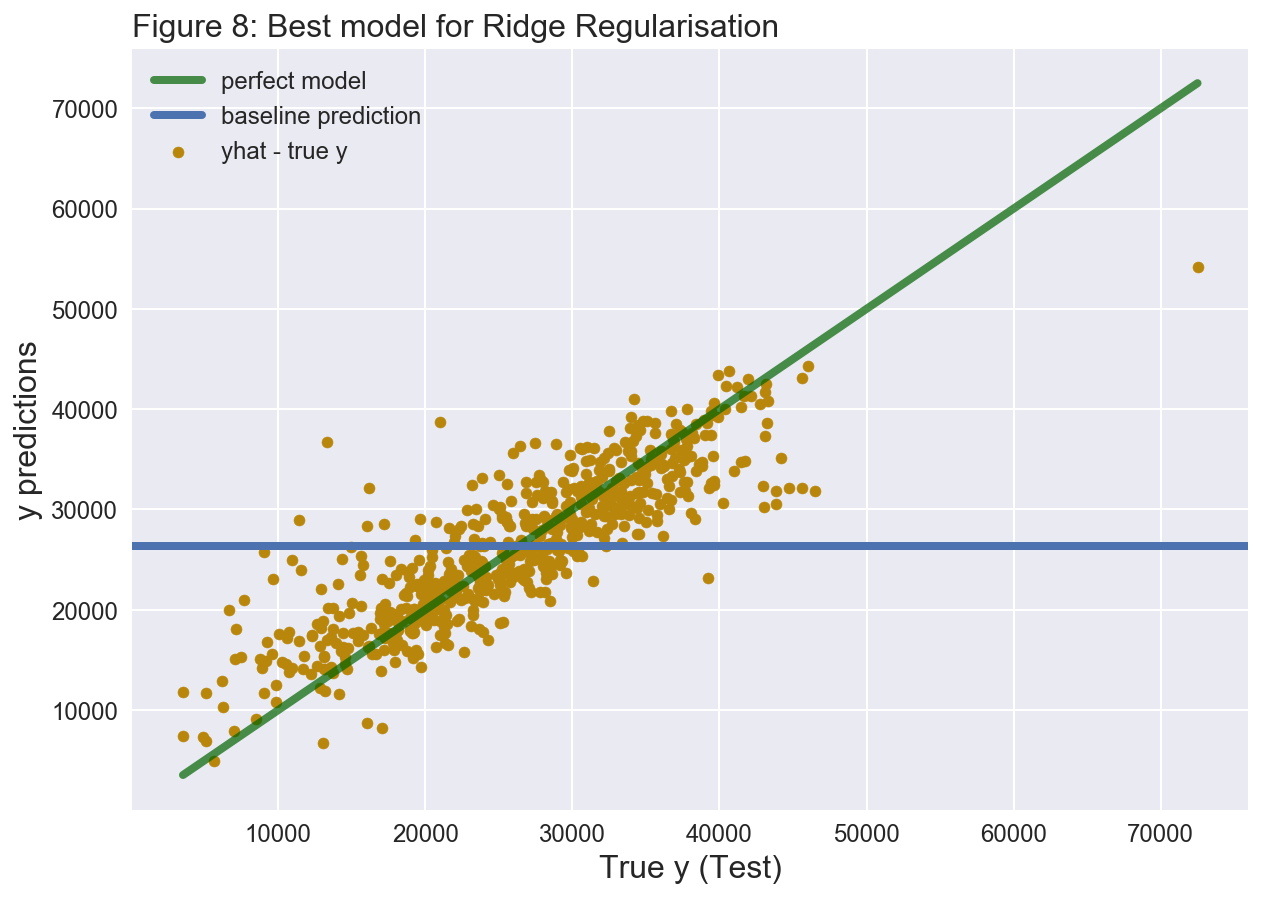

In [35]:
# Make predictions using the test set
preds = grid_ridge.predict(Xt)
print 'RMSE on test data:', np.sqrt(mean_squared_error(y_test, preds))

# Plot the predictions vs. the test set
plot_y_yhat(y_test, preds)
plt.title('Figure 8: Best model for Ridge Regularisation', loc = 'left', fontsize = fs)
plt.xlabel("True y (Test)")
plt.show()

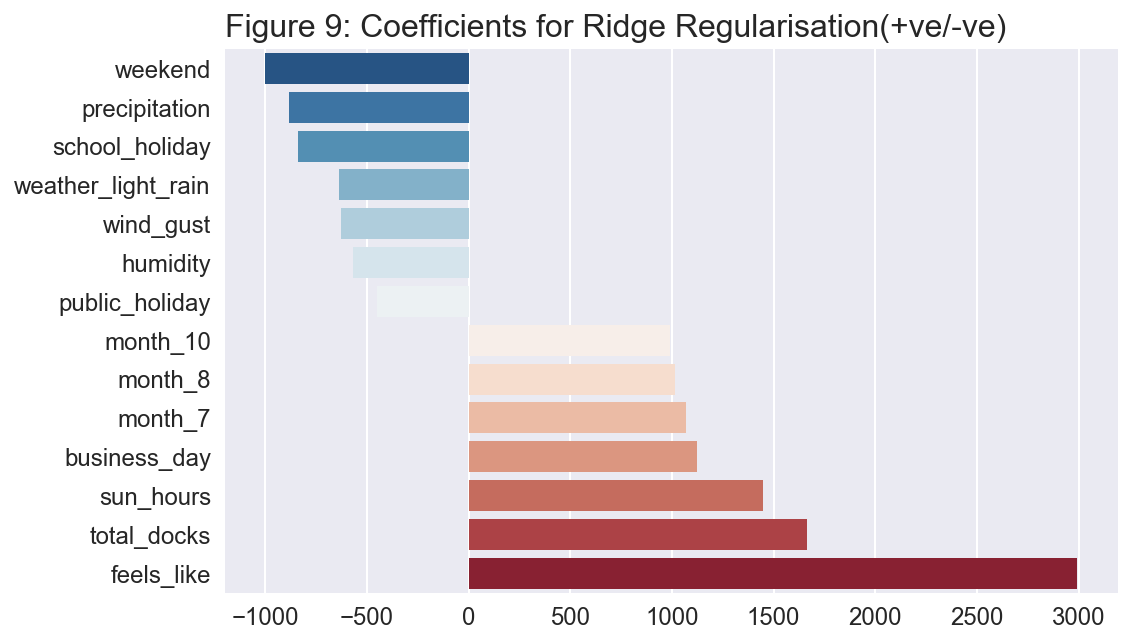

In [36]:
coef = pd.Series(grid_ridge.best_estimator_.coef_, index = Xtot.columns)
sort_coef = pd.concat([coef.sort_values().head(7),
                      coef.sort_values().tail(7)])

sns.barplot(y = sort_coef.index, x = sort_coef.values, palette = "RdBu_r")
plt.title("Figure 9: Coefficients for Ridge Regularisation(+ve/-ve)", loc = 'left', fontsize = fs)
plt.show()

In [37]:
# Use GridSearch to test Lasso (L1) regularisation
alpha  = [1, 2, 5, 10, 15, 20, 25]
lasso_m = Lasso()
lasso_params = {'max_iter':[3000],'alpha':alpha}
grid_lasso = GridSearchCV(lasso_m, lasso_params, cv=5, scoring = 'neg_mean_squared_error')

# Best parameters when fit with the whole training set:
grid_lasso.fit(Xs, y_train)
print grid_lasso.best_params_

RMSE = np.sqrt(-(grid_lasso.best_score_))
print 'Best score:', RMSE

method.append('LR_GSCV_Lasso')
RMSE_metric.append(RMSE)

{'alpha': 5, 'max_iter': 3000}
Best score: 4446.50666599


RMSE on test data: 4560.87174086


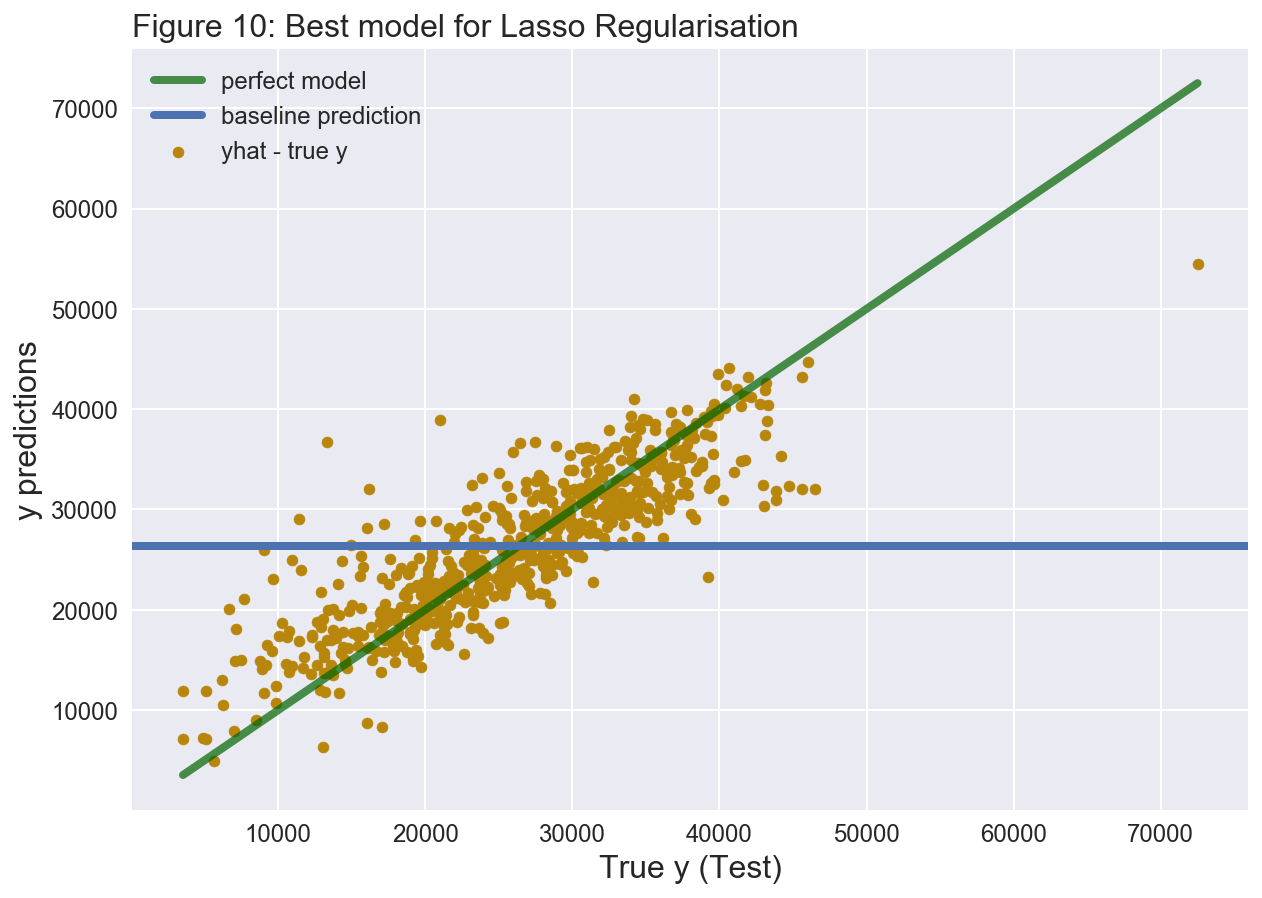

In [38]:
# Make predictions using the test set
preds = grid_lasso.predict(Xt)
print 'RMSE on test data:', np.sqrt(mean_squared_error(y_test, preds))

# Plot the predictions vs. the test set
plot_y_yhat(y_test, preds)
plt.title("Figure 10: Best model for Lasso Regularisation", loc = 'left', fontsize = fs)
plt.xlabel("True y (Test)")
plt.show()

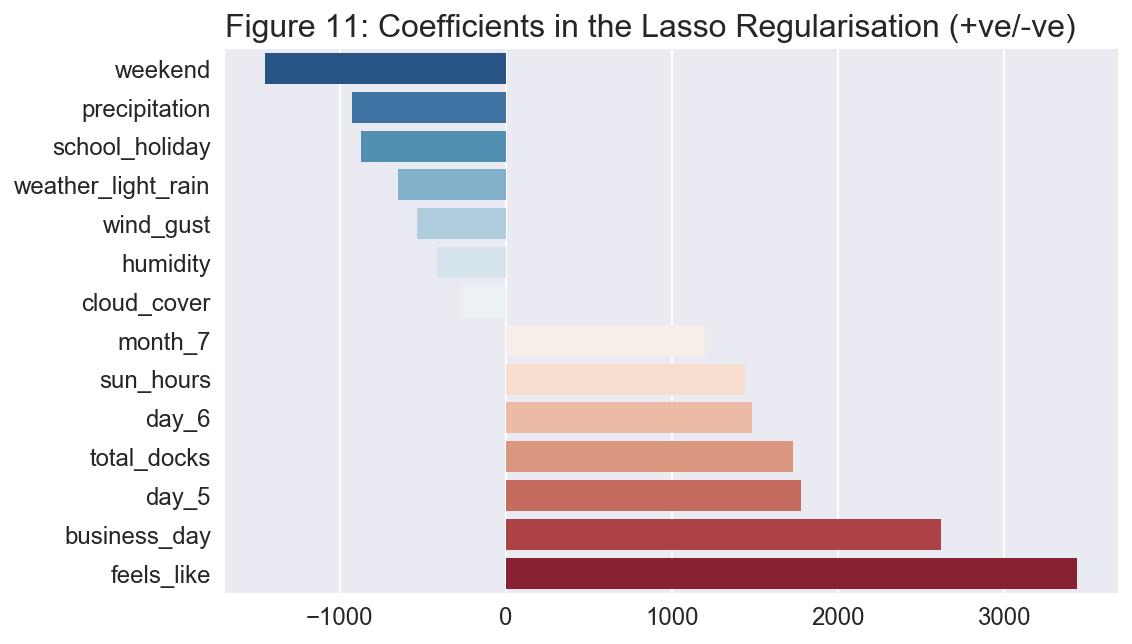

In [39]:
coef = pd.Series(grid_lasso.best_estimator_.coef_, index = Xtot.columns)
sort_coef = pd.concat([coef.sort_values().head(7),
                      coef.sort_values().tail(7)])

sns.barplot(y = sort_coef.index, x = sort_coef.values, palette = "RdBu_r")
plt.title("Figure 11: Coefficients in the Lasso Regularisation (+ve/-ve)", loc = 'left', fontsize = fs)
plt.show()

In [40]:
# Use GridSearch to test Elastic Net (combination of L2/L1) regularisation
elastic_m = ElasticNet()
elastic_params = {'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200], 'l1_ratio': np.arange(0.1, 0.9, 0.1) }
grid_elastic = GridSearchCV(elastic_m, elastic_params, cv=5, scoring = 'neg_mean_squared_error')

# Best parameters when fit with the whole training set:
grid_elastic.fit(Xs, y_train)
print grid_elastic.best_params_

RMSE = np.sqrt(-(grid_elastic.best_score_))
print 'Best score:', RMSE

method.append('LR_GSCV_Elastic')
RMSE_metric.append(RMSE)

{'alpha': 0.1, 'max_iter': 3000, 'l1_ratio': 0.80000000000000004}
Best score: 4444.36848311


RMSE on test data: 4545.25274147


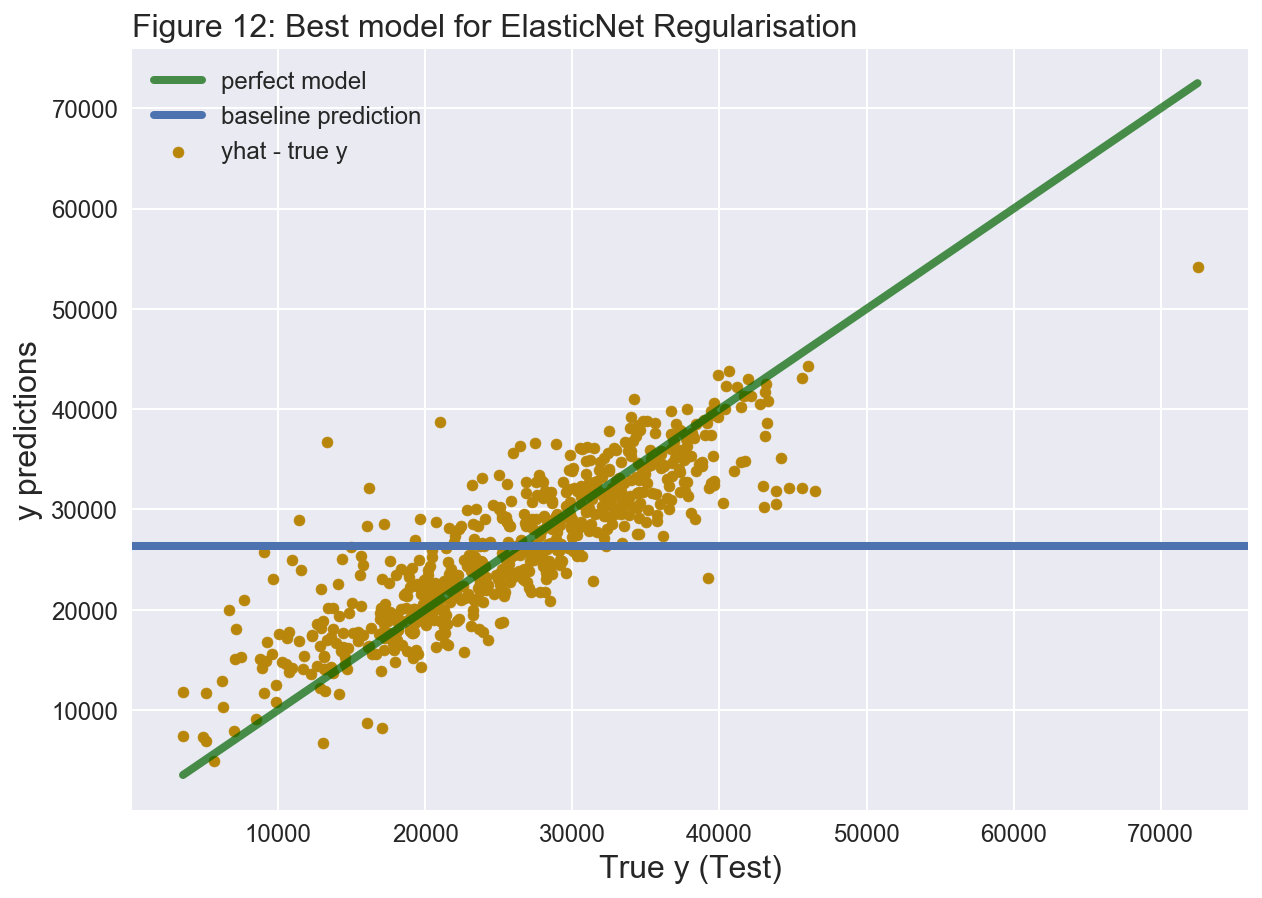

In [41]:
# Make predictions using the test set:
preds = grid_elastic.predict(Xt)
print 'RMSE on test data:', np.sqrt(mean_squared_error(y_test, preds))

# Plot the predictions vs. the test set
plot_y_yhat(y_test, preds)
plt.title('Figure 12: Best model for ElasticNet Regularisation', loc = 'left', fontsize = fs)
plt.xlabel("True y (Test)")
plt.show()

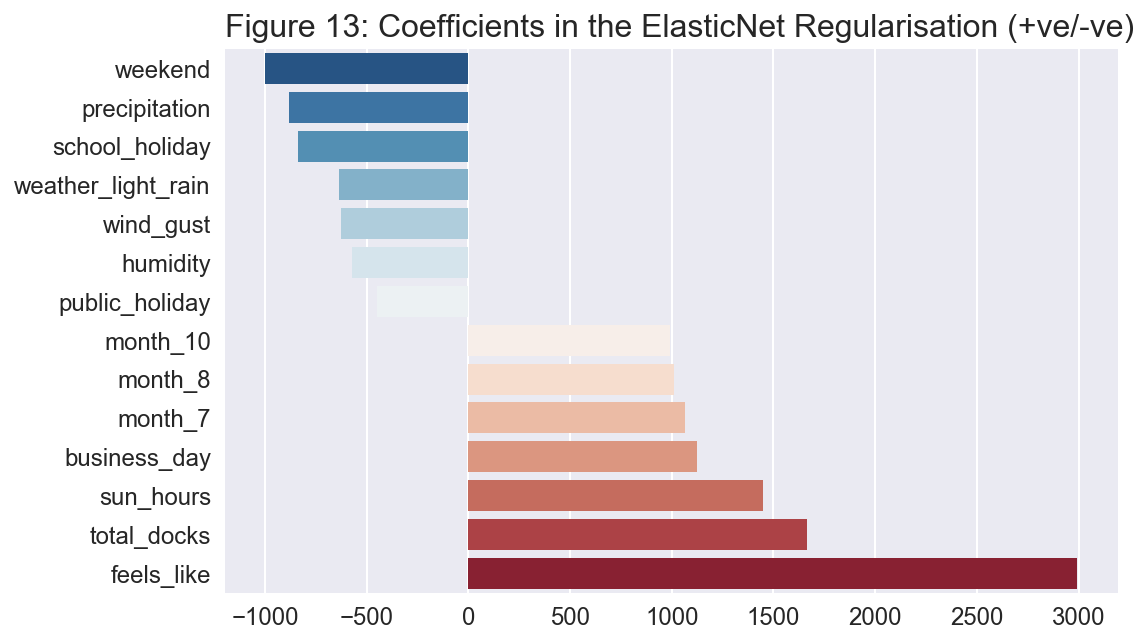

In [42]:
coef = pd.Series(grid_elastic.best_estimator_.coef_, index = Xtot.columns)
sort_coef = pd.concat([coef.sort_values().head(7),
                      coef.sort_values().tail(7)])

sns.barplot(y = sort_coef.index, x = sort_coef.values, palette = "RdBu_r")
plt.title("Figure 13: Coefficients in the ElasticNet Regularisation (+ve/-ve)", loc = 'left', fontsize = fs)
plt.show()

### Support Vector Regressor
The 'best' model has a linear kernel and C equal to 100, it performs worse than all of the Linear Regression models.

In [43]:
model_rbf = SVR()

params_rbf = [{'kernel': ['rbf'], 'gamma': np.logspace(-5, 2, 3),
                     'C': np.logspace(-3, 3, 6)},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

grid_svm = GridSearchCV(model_rbf, param_grid=params_rbf, cv=5, verbose=1, n_jobs = -1, scoring = 'neg_mean_squared_error')

# Best parameters when fit with the whole training set:
grid_svm.fit(Xs, y_train)
print grid_svm.best_params_

RMSE = np.sqrt(-(grid_svm.best_score_))
print 'Best score:', RMSE

method.append('SVM_GS')
RMSE_metric.append(RMSE)

# Making predictions using the test set:
preds = grid_svm.predict(Xt)
print 'RMSE on test set:', np.sqrt(mean_squared_error(y_test, preds))

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   11.8s finished


{'kernel': 'linear', 'C': 100}
Best score: 4490.88122047
RMSE on test set: 4590.85895025


### Ensemble Methods

Ensembling refers to creating mutiple models and then combining them to produce improved results. 

#### Random Forest Regressor

*Why use this algorithm?* Straight out of the box decision trees tend to grow deep and as a result learn highly irregular patterns leading to an overfit of the training set (high variance). **Bagging** can help to mitigate this problem by exposing different trees to different sub-samples of the whole training set. 

Random Forest uses a modified decision tree learning algorithm that selects, at each candidate split, a random subset of the features. Often one or a few features are very strong predictors for the target (e.g. temperatures and variables related to it in our case) and are always selected in bagging base trees. Selecting a random subset of features at each split avoids this correlation. 

The gridsearched best estimated model has an RMSE of 4122, fitted with `n_estimators` of 200, `max_features` of 25 and `min_samples_leaf` of 2. `feels_like`, `sun_hours` and `business_day` are the highest ranked features.

In [44]:
model5 = RandomForestRegressor()

gs_params_RF = { 'n_estimators' : [50, 70, 90, 150, 200, 300, 400], 'min_samples_leaf' : [2,3,4], 'max_features': [10, 15, 20, 25, 30, 35]}

grid_rf = GridSearchCV(model5, gs_params_RF, cv=5, verbose=1, n_jobs = -1, scoring = 'neg_mean_squared_error')

grid_rf.fit(Xs, y_train)
print grid_rf.best_params_

RMSE = np.sqrt(-(grid_rf.best_score_))
print 'Best score:', RMSE

method.append('RFR_GS')
RMSE_metric.append(RMSE)

best_gs_rf = grid_rf.best_estimator_
preds = best_gs_rf.predict(Xt)
print 'RMSE on test set:', np.sqrt(mean_squared_error(y_test, preds))

Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:  5.9min finished


{'max_features': 25, 'n_estimators': 300, 'min_samples_leaf': 2}
Best score: 4123.40174449
RMSE on test set: 4108.41122308


In [85]:
# Top 5 features in terms of importance
zipped = zip(Xt.columns, best_gs_rf.feature_importances_)
zipped.sort(key = lambda t: t[1], reverse = True)

for i, j in enumerate(zipped[:10], 1):
    print i, j

1 ('feels_like', 0.44279961451919403)
2 ('sun_hours', 0.091869777700232913)
3 ('business_day', 0.076245830769196152)
4 ('humidity', 0.071183512526732051)
5 ('total_docks', 0.070936769622271287)
6 ('min_temp', 0.061193973482356619)
7 ('cloud_cover', 0.027954699523557284)
8 ('weekend', 0.027801932022886659)
9 ('wind_gust', 0.026323768112055543)
10 ('wind_dir_deg', 0.025041388907431659)


#### Gradient Boosting Regressor
*Why use this algorithm?* Gradient boosting is able to provide smooth detailed predictions by combining many trees of very limited depth. Each subsequent tree is fitted to the residuals of the data. Hence each subsequent iteration is slowly improving the overall strong learner by improving its performance in poorly-performing regions of the feature space. Least Absolute Deviation (LAD) will be tested as well as Least Squares for the loss function.<br>
<br>
The RMSE and R2 are improved using the Least Squares loss function rather than LAD but MAE is lower when LAD is used. With an RMSE of 4015, Gradient Boosting with least squares is performing better than the grid searched Random Forest Regressor.

In [46]:
model3 = GradientBoostingRegressor(loss = 'lad')

RMSE = RMSE_CV(model3)
print "RMSE:", RMSE
print "MAE:", MAE_CV(model3)
print "R2:", R2_CV(model3)

method.append('GBR_LAD')
RMSE_metric.append(RMSE)

RMSE: 4057.45
MAE: 2058.0
R2: 0.7741


In [47]:
model4 = GradientBoostingRegressor() # Uses least squares loss function by default.

RMSE = RMSE_CV(model4)
print "RMSE:", RMSE
print "MAE:", MAE_CV(model4)
print "R2:", R2_CV(model4)

method.append('GBR_LS')
RMSE_metric.append(RMSE)

RMSE: 4013.46
MAE: 2171.0
R2: 0.7798


#### GradientBoost Regressor GridSearch
The following parameters have been tested:
* n_estimators: number of boosting stages to perform, technique is fairly robust to overfitting so large numbers usually give better performance. 
* max_features: number of features to consider when looking for the best split.
* learning_rate: shrinks the contribution of each tree by the learning rate.
* max_depth: maximum depth of the individual regression estimators, limits number of nodes

The best RMSE from the training data is 3832, with the optimised model yielding an RMSE on the test set of 3820 and 2012 MAE. This model is fit with `max_features` of 10, `loss` of least squares, `learning_rate` of 0.1, `n_estimators` at 400 and `max_depth` of 3. `total_docks`, `wind_dir_deg` and `humidity` are the highest ranked features using `.features_importances_`. `wind_dir_deg` has not appeared as a key variable in any of the other models, and did not exhibit a particularly strong correlation coefficient with `total_journeys` during EDA.

In [48]:
# Using model4 which was instantiated in the previous section.
gs_params_GB = {'loss':['ls', 'lad'], 'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4] , 'max_depth': [1, 2, 3, 4], 'max_features': [10,15,20,25,30,35],'n_estimators':[50, 70, 90, 150, 200, 300, 400]}

grid_gb = GridSearchCV(model4, gs_params_GB, cv=5, verbose=1, n_jobs = -1, scoring = 'neg_mean_squared_error')

grid_gb.fit(Xs, y_train)
print 'Best parameters:', grid_gb.best_params_

RMSE = np.sqrt(-(grid_gb.best_score_))
print 'Best score:', RMSE

method.append('GBR_GS')
RMSE_metric.append(RMSE)

best_gs_gb = grid_gb.best_estimator_
preds = best_gs_gb.predict(Xt)
print 'RMSE on test set:', np.sqrt(mean_squared_error(y_test, preds))
print 'MAE on test set:', median_absolute_error(y_test, preds)

Fitting 5 folds for each of 1680 candidates, totalling 8400 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 548 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 813 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1163 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1613 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2263 tasks      | elapsed: 64.3min
[Parallel(n_jobs=-1)]: Done 2913 tasks      | elapsed: 66.0min
[Parallel(n_jobs=-1)]: Done 3663 tasks      | elapsed: 68.9min
[Parallel(n_jobs=-1)]: Done 4513 tasks      | elapsed: 78.8min
[Parallel(n_jobs=-1)]: Done 5463 tasks      | elapsed: 81.2min
[Parallel(n_jobs=-1)]: Done 6513 tasks      | elapsed: 83.9min
[Parallel(n_jobs=-1)]: Done 7663 tasks      | elapsed: 86.7min
[Parallel(n_jobs=-1)]: Done 8400 out of 8400 | elapsed: 89.3min finished


Best parameters: {'max_features': 10, 'loss': 'ls', 'learning_rate': 0.1, 'n_estimators': 400, 'max_depth': 3}
Best score: 3832.00187062
RMSE on test set: 3820.41633024
MAE on test set: 2012.31468735


In [151]:
# Boosting always focuses on the part of data that is not correctly predicted. Hence, over the
# course of the iterations, this focus will change. This may explain why these features rank highly
# if they have a particular influence on the harder to predict observations.

zipped = zip(Xt.columns, best_gs_gb.feature_importances_)
zipped.sort(key = lambda t: t[1], reverse = True)

for i, j in enumerate(zipped[:10], 1):
    print i, j

1 ('total_docks', 0.12900982088050189)
2 ('wind_dir_deg', 0.10567852328121763)
3 ('humidity', 0.095389010280088588)
4 ('wind_gust', 0.081983096441411135)
5 ('feels_like', 0.081411028288522744)
6 ('min_temp', 0.074459126501624062)
7 ('cloud_cover', 0.07152545359468454)
8 ('sun_hours', 0.065533791463011012)
9 ('precipitation', 0.046709802443265058)
10 ('school_holiday', 0.024799310628579974)


ELI5 (Explain it Like I'm 5) provides two main ways to determine how a regression model is working:
* Inspect model parameters and try to figure out how the model works globally (`show_weights()`)
* Inspect an individual prediction of a model, try to figure out why the model makes the decision it makes (`show_prediction()`)

Permutation Importance allows feature importances to be determined by measuring how score decreases when a feature is not available. For the gradient boosting regressor model, this outputs top three features of `feels_like`, `total_docks` and `business_day` which have ranked highly repeatedly in the other models.

In [148]:
# Gradient Boosting Regressor set up with same hyperparameters found by gridsearching
# Due to relatively few columns in dataset, computing feature importances with ELI5 PermutationImportsance: 
gbr_eli5 = GradientBoostingRegressor(learning_rate=0.1, n_estimators = 400, max_features = 10, max_depth = 3).fit(Xs, y_train)
perm = PermutationImportance(gbr_eli5).fit(Xt, y_test)
eli5.show_weights(perm, feature_names = Xt.columns.values)


In [174]:
# Focusing on observation #2 in the test set, y true: 27060
# Feels like 2 deg C, business day, 2.9 hours of sun and 18361 docks installed

show_prediction(gbr_eli5.fit(Xt, y_test), Xt.iloc[1, :], top = 10, show_feature_values=True)

# The highest positive contributing features are total_docks and business_day, the largest negative
# contributing features are feels_like, min_temp. These make sense as it was a business day, there
# were lots of docks active on the network (relatively recent observation) and it only felt like 2 deg

In [179]:
# Focusing on observation #201 in the test set, y true = 32004
# Feels like 19 deg C, business day, 7.7 hours of sun and 17120 docks installed

show_prediction(gbr_eli5.fit(Xt, y_test), Xt.iloc[200, :], show_feature_values=True, top = 10)

# The highest positive contributing features are humidity, sun hours, feels_like, the largest negative
# contributing feature is total_docks. It was a very sunny day so this makes sense, as does feels_like
# It's unclear why humidity is having a relatively large impact on this prediction.

#### Comparison of Random Forest and Gradient Boosting
Random Forest uses fully grown decision trees (low bias, high variance). The trees are made uncorrelated to maximize the decrease in variance. It cannot reduce bias, so ideally large unpruned trees are needed so the bias is already low initially. It grows trees in parallel. 

Boosting algorithms can play a crucial role in dealing with bias variance trade-off.  Unlike bagging algorithms, which only controls for high variance. Gradient Boost is based on shallow trees - weak base learners with high bias, low variance. Each subsequent tree is fitted to the residuals of the data. Hence each subsequent iteration is slowly improving the overall strong learner by improving its performance in poorly-performing regions of the feature space. This reduces the bias, but also the variance by aggregation of output from many sequential models. No weighting for gradient boosting, sum together at end.

The models are successively built using the training set, varying the n_estimators and max_features and the resulting errors visualised. The hyperparameters tested were:

* *n_estimators:* RandomForest outperforms GradientBoosting when number of estimators is low - this is to be expected as it uses fully grown decision trees. As this value increases the RMSE begins to converge, until c.200 estimators where both are relatively stable, and GB is slightly outperforming RF.<br>
<br>
* *max_features:* Note: n_estimators set to 200 so GB performs consistently better than RF. For RMSE, RF is improving consistently until 20 where it levels out, whereas GB appears to be optimal at 10 features. MAE is fairly unstable over this hyperparameter interval, particularly for GB and does not stabilise for either algorithm. 

In [50]:
values = sorted(list(set(np.logspace(0, 3, num=20, endpoint=True, base=10.0).astype(int))))

In [51]:
score_list = []
for n in values:
    models = [('GradientBoost',GradientBoostingRegressor(loss = 'ls', random_state=1, n_estimators=n)),
          ('RandomForest',RandomForestRegressor(random_state=1, n_estimators=n))
             ]
    for model in models:
        score = RMSE_CV(model[1])
        MAE = MAE_CV(model[1])
        score_list.append([model[0], n, score, MAE])

In [52]:
scores = pd.DataFrame(score_list,columns=['model','estimators','rmse', 'mae'])
scores.head()

model  estimators     rmse     mae
0  GradientBoost           1  8038.22  5729.0
1   RandomForest           1  5947.74  3145.0
2  GradientBoost           2  7598.06  5366.0
3   RandomForest           2  5143.37  2892.0
4  GradientBoost           4  6862.20  4711.0

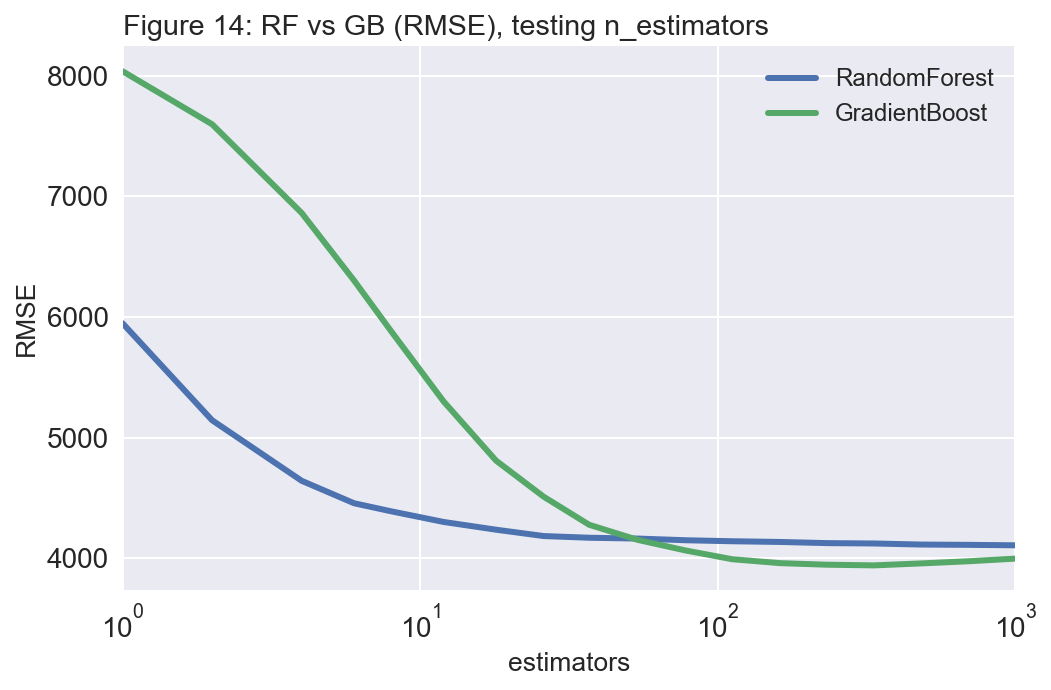

In [68]:
groups = scores.groupby('model')

fig, ax = plt.subplots()
for group in groups.groups.keys():
    groups.get_group(group).plot(x='estimators', y='rmse', ax=ax,
                                 label=group, lw=3, fontsize=14, logx=True)

plt.title('Figure 14: RF vs GB (RMSE), testing n_estimators', loc = 'left')
plt.ylabel('RMSE')
plt.show()

# The models are both minimised in terms of RMSE, at ~200 for n_estimators.

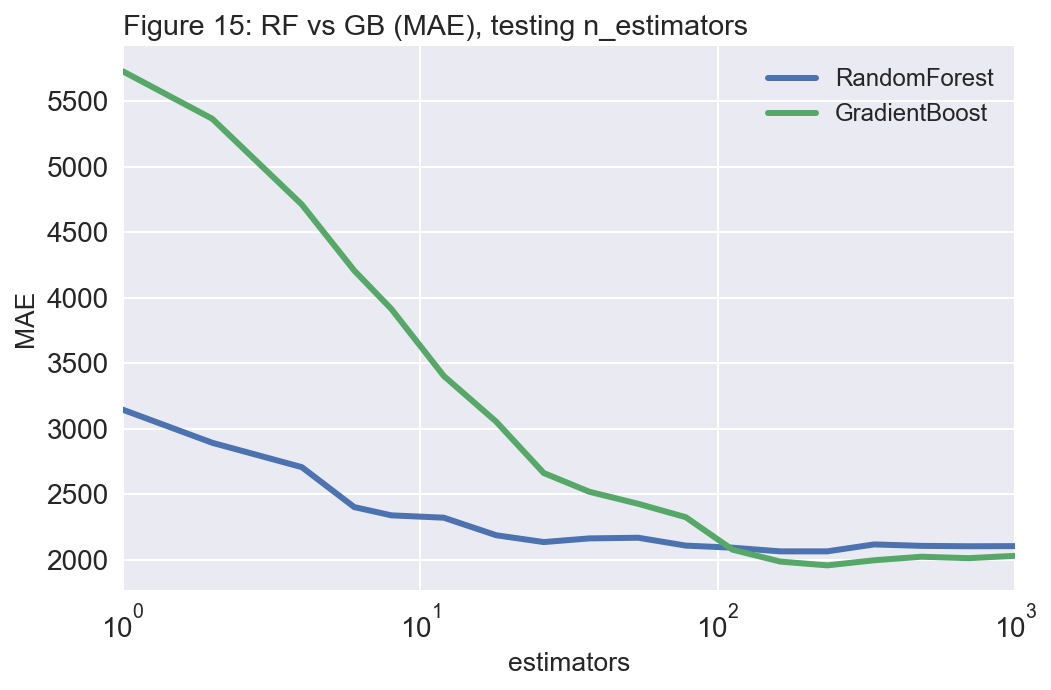

In [70]:
fig, ax = plt.subplots()
for group in groups.groups.keys():
    groups.get_group(group).plot(x='estimators', y='mae', ax=ax,
                                 label=group, lw=3, fontsize=14, logx=True)

plt.title('Figure 15: RF vs GB (MAE), testing n_estimators', loc = 'left')
plt.ylabel('MAE')
plt.show()

In [57]:
max_features = np.arange(5,40,5)
score_list = []
for n in max_features:
    models = [('GradientBoost',GradientBoostingRegressor(random_state=1, n_estimators=200, max_features = n, alpha = 0.01)),
          ('RandomForest',RandomForestRegressor(random_state=1, n_estimators=200, max_features = n))
             ]
    for model in models:
        RMSE = RMSE_CV(model[1])
        MAE = MAE_CV(model[1])
        score_list.append([model[0], n, RMSE, MAE])

In [58]:
df_scores = pd.DataFrame(score_list,columns=['model','max_features','rmse', 'mae'])
df_scores.head()

model  max_features     rmse     mae
0  GradientBoost             5  3932.84  2233.0
1   RandomForest             5  4241.51  2544.0
2  GradientBoost            10  3850.70  2101.0
3   RandomForest            10  4144.82  2331.0
4  GradientBoost            15  3866.59  2042.0

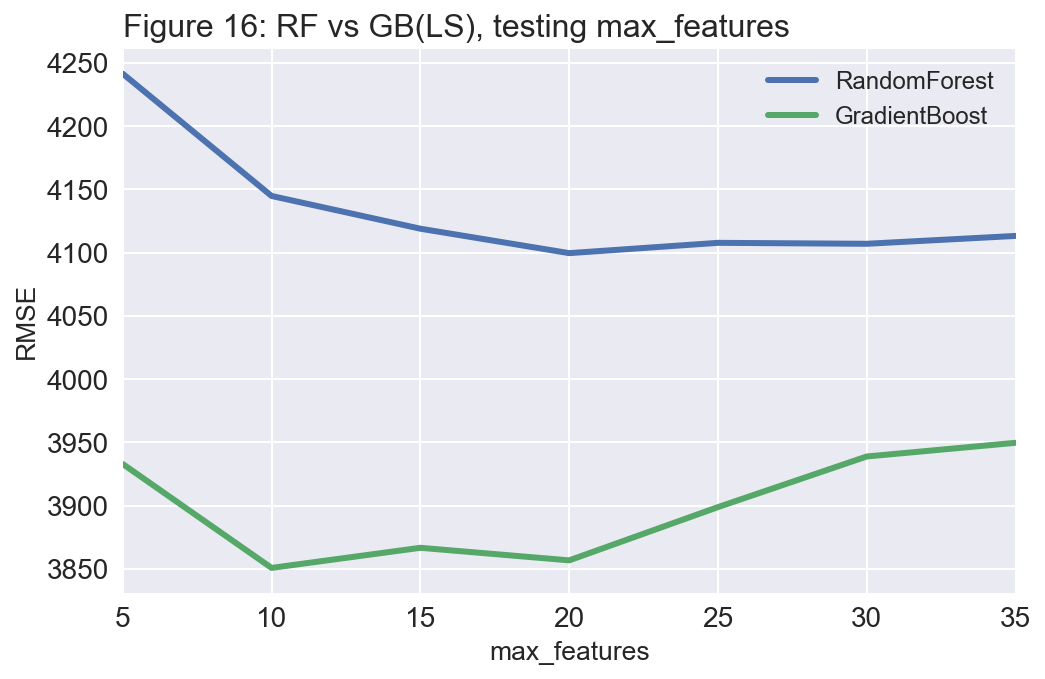

In [59]:
groups = df_scores.groupby('model')

fig, ax = plt.subplots()
for group in groups.groups.keys():
    groups.get_group(group).plot(x='max_features', y='rmse', ax=ax,
                                 label=group, lw=3, fontsize=14)

plt.title('Figure 16: RF vs GB (RMSE), testing max_features', loc = 'left', fontsize = fs)
plt.ylabel('RMSE')
plt.show()

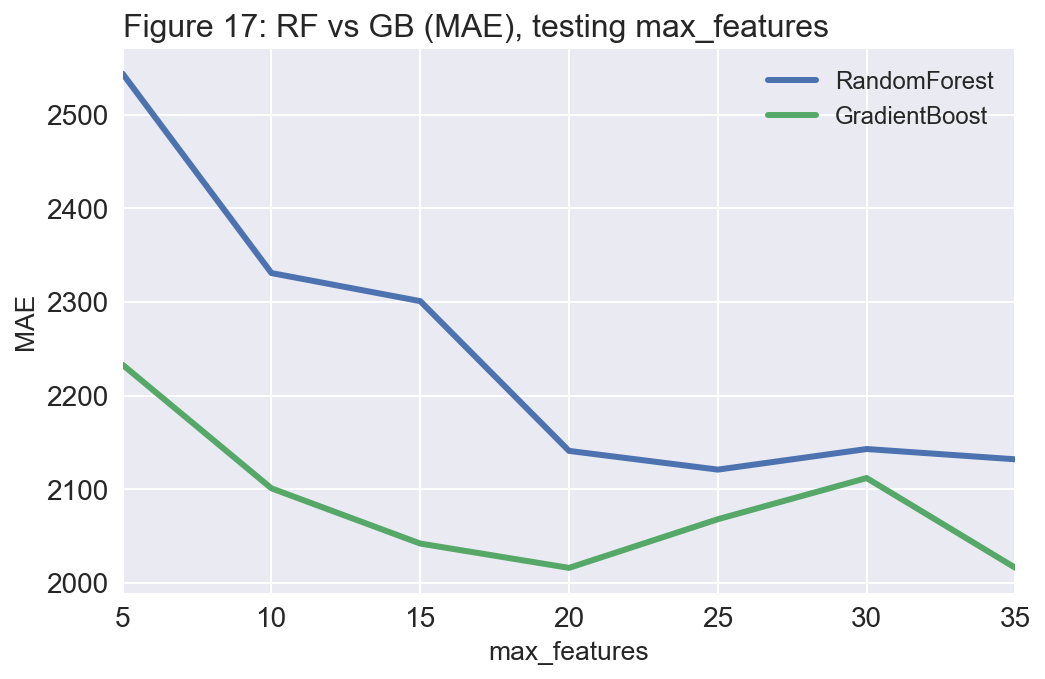

In [61]:
groups = df_scores.groupby('model')

fig, ax = plt.subplots()
for group in groups.groups.keys():
    groups.get_group(group).plot(x='max_features', y='mae', ax=ax,
                                 label=group, lw=3, fontsize=14)

plt.title('Figure 17: RF vs GB (MAE), testing max_features', loc = 'left', fontsize = fs)
plt.ylabel('MAE')
plt.show()

###  Summary - Predicting Daily Hires
* Iterations included multi-linear regression along with Lasso, Ridge and ElasticNet regularisation, testing log transformation of the target variable and Support Vector Machines. 
* All three types of regularisation performed similarly based on RMSEs similar to plain linear regression cross validation. Random Forest provided a step change improvement in performance, with an RMSE of 4122.
* During cross-validation, the best performing model overall was the Gradient Boost Regressor with an RMSE of 3832 (see Figure 20). This produced a final RMSE on the test set of 3820 and MAE of 2012.
* The highest ranked features were `total_docks`, `wind_dir_deg` and `humidity`.
* Gradient boosting is able to optimise for variance and bias by aggregating many shallow decision trees which are sequentially built on the residuals from previous iterations.

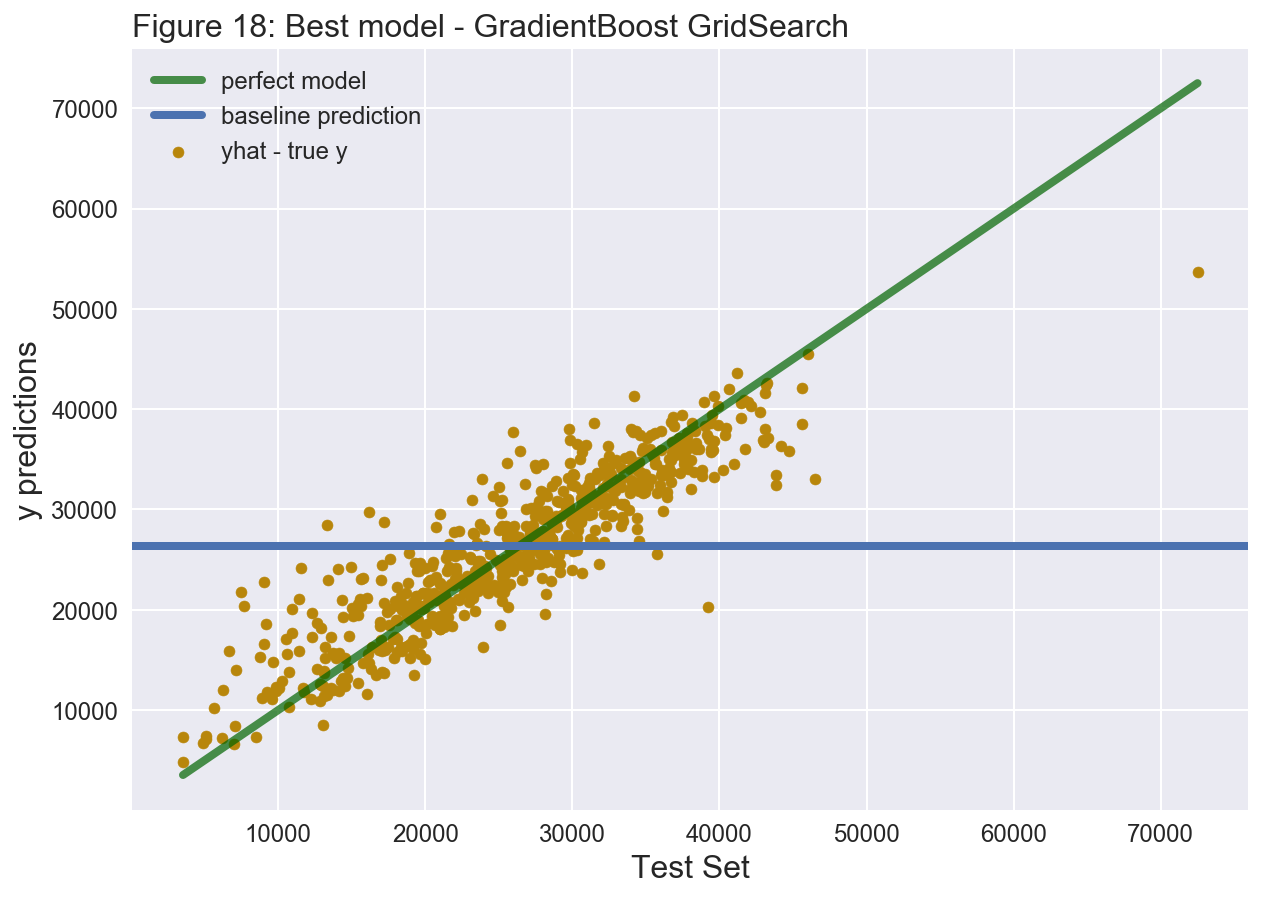

In [64]:
plot_y_yhat(y_test, preds)
plt.title('Figure 18: Best model - GradientBoost GridSearch ', loc = 'left', fontsize = fs)
plt.xlabel("Test Set")
plt.show()

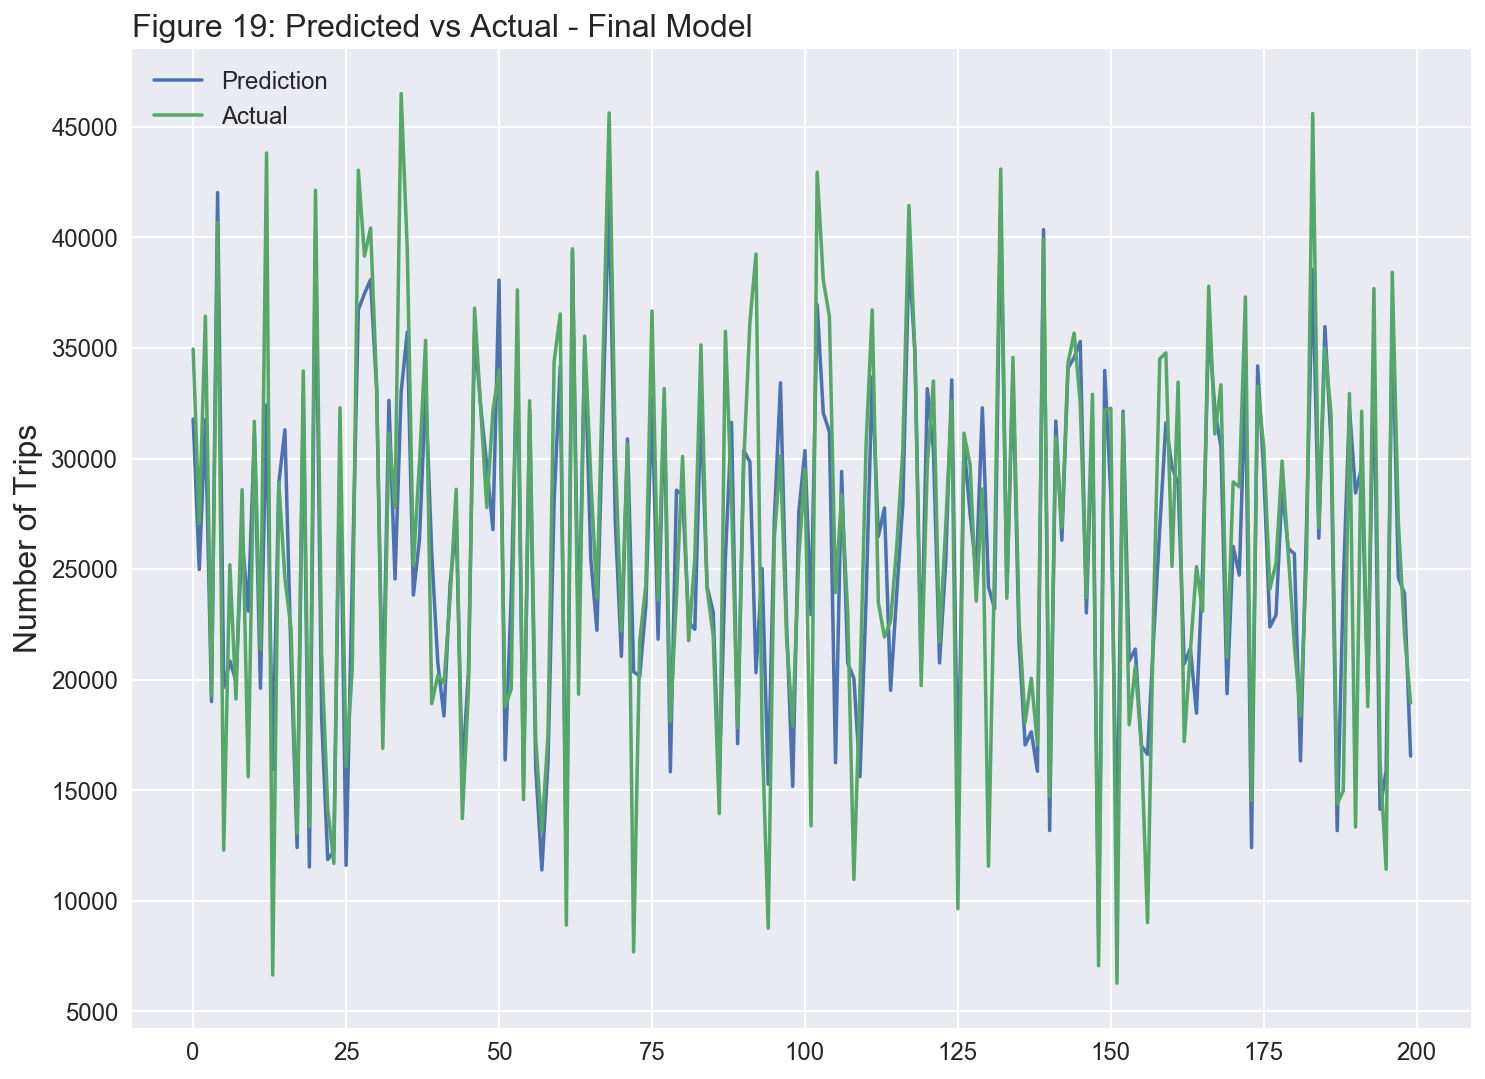

In [63]:
fs = 16
plt.figure(figsize=(12,9))
plt.plot(preds[:200]) # Filtered to first 200 points for visualisation
plt.plot(y_test[:200])
plt.legend(['Prediction', 'Actual'])
plt.ylabel("Number of Trips", fontsize = fs)
plt.xlabel("", fontsize = fs)
plt.title("Figure 19: Predicted vs Actual - Final Model", fontsize = fs, loc = 'left')
plt.show()

In [65]:
summary = pd.DataFrame({'Method': method, 'RMSE':RMSE_metric})

In [66]:
summary

Method         RMSE
0  LinearRegressionCV  4443.810000
1       LR_GSCV_Ridge  4444.457602
2       LR_GSCV_Lasso  4446.506666
3     LR_GSCV_Elastic  4444.368483
4              SVM_GS  4490.881220
5              RFR_GS  4123.401744
6             GBR_LAD  4057.450000
7              GBR_LS  4013.460000
8              GBR_GS  3832.001871

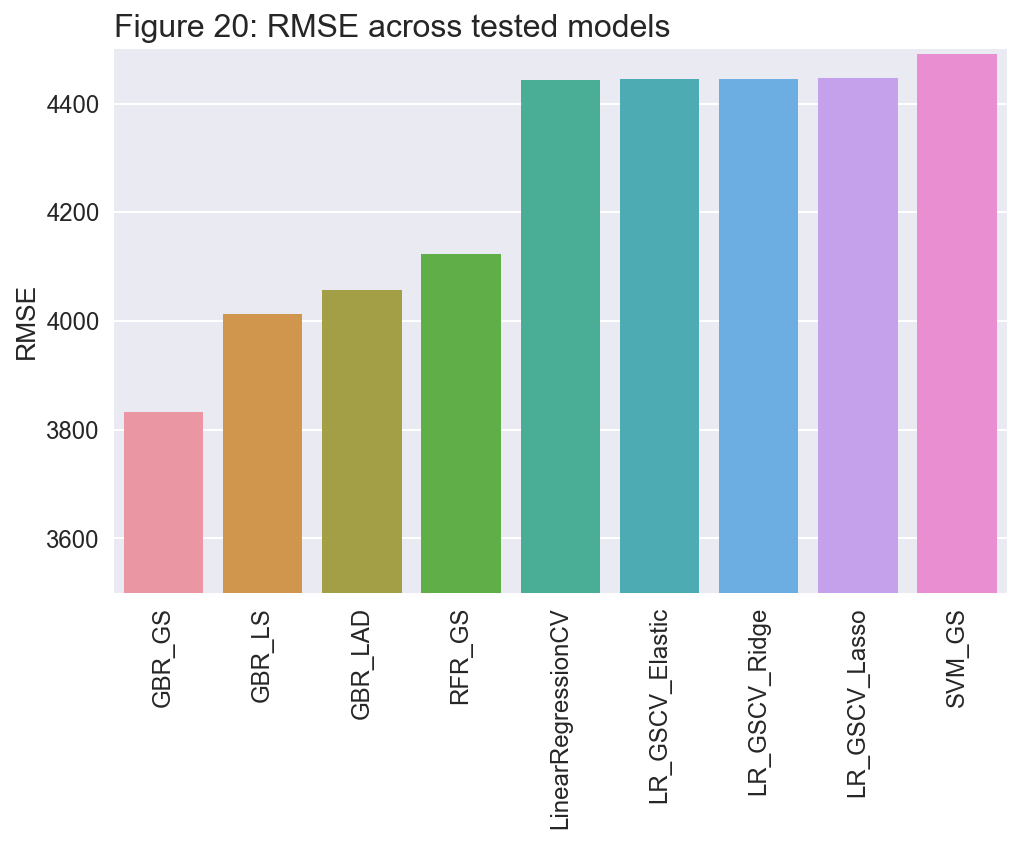

In [67]:
sns.barplot(data=summary.sort_values('RMSE', ascending = True), x = 'Method', y = 'RMSE')
plt.xticks(rotation = 90)
plt.title("Figure 20: RMSE across tested models", fontsize = fs, loc = 'left')
plt.xlabel('')
plt.ylim([3500,4500])
plt.show()


### Network Analysis

Network theory is the study of graphs as a representation of relations between discrete objects. A graph consists of a set of objects V called vertices and a set of edges E connecting pairs of vertices. The Santander Cycles system is an example of a network, with the docking stations presenting as *nodes* and the point A - point B journeys that users take as *edges*.

Using station id would be better for network analysis, since the docking station names can be very long. However, on closer inspection the start_station_id and end_station_id often have repetition for the same station e.g. Ada Street, Hackney Central is referenced as both 718 and 300040. 300040 is only used 269 times, all between 31st Aug and 6th September so it seems likely the ids were recorded incorrectly for some reason during this period. Therefore, the station names will be used but converted to a numeric for the analysis using enumerate.

In [ ]:
X2016 = pd.read_csv('X2016_geo.csv', index_col = 0)

In [72]:
X2016.head()

bike_id  duration             end_date  end_station_id  \
0   8452.0    1200.0  2016-01-01 00:24:00           118.0   
1   8452.0    1200.0  2016-01-01 00:24:00           118.0   
2    529.0    1200.0  2016-01-01 00:24:00           118.0   
3   7151.0    1080.0  2016-01-01 00:22:00           251.0   
4   7151.0    1080.0  2016-01-01 00:22:00           251.0   

                      end_station_name  rental_id           start_date  \
0           Rochester Row, Westminster   50608187  2016-01-01 00:04:00   
1           Rochester Row, Westminster   50608187  2016-01-01 00:04:00   
2           Rochester Row, Westminster   50608186  2016-01-01 00:04:00   
3  Brushfield Street, Liverpool Street   50608190  2016-01-01 00:04:00   
4  Brushfield Street, Liverpool Street   50608190  2016-01-01 00:04:00   

   start_station_id       start_station_name  start_lat  start_lon    end_lat  \
0               419  Chelsea Bridge, Pimlico  51.485821  -0.149004  51.495827   
1               419  Chelsea Bridge, Pimlico  51.485821  -0.149004  51.495827   
2               419  Chelsea Bridge, Pimlico  51.485821  -0.149004  51.495827   
3                66  Holborn Circus, Holborn  51.517950  -0.108657  51.518908   
4                66  Holborn Circus, Holborn  51.517950  -0.108657  51.518908   

    end_lon  
0 -0.135478  
1 -0.135478  
2 -0.135478  
3 -0.079249  
4 -0.079249

In [73]:
# Check for null values
X2016.isnull().sum()

bike_id               0
duration              0
end_date              0
end_station_id        0
end_station_name      0
rental_id             0
start_date            0
start_station_id      0
start_station_name    0
start_lat             0
start_lon             0
end_lat               0
end_lon               0
dtype: int64

In [74]:
# Create dataframe of routes and the number of times each route has been cycled between
routes = X2016.groupby(['start_station_name', 'end_station_name']).size().unstack(fill_value = 0)

In [90]:
# The stations ids are non-unique so can not be used as unique identifiers:
print X2016[X2016.start_station_name == 'Ada Street, Hackney Central'].start_station_id.unique()
X2016[X2016.start_station_id == 300040].head()

[   718 300040]


bike_id  duration             end_date  end_station_id  \
7118210   5849.0    1320.0  2016-08-31 04:24:00          3428.0   
7120800   8722.0     900.0  2016-08-31 07:55:00          2699.0   
7120972   5122.0     840.0  2016-08-31 07:57:00          3467.0   
7120991  12419.0     360.0  2016-08-31 07:50:00        200244.0   
7121209   7866.0     720.0  2016-08-31 08:00:00          3438.0   

                            end_station_name  rental_id           start_date  \
7118210           Pancras Road, King's Cross   57834933  2016-08-31 04:02:00   
7120800                Snow Hill, Farringdon   57837579  2016-08-31 07:40:00   
7120972                 Dock Street, Wapping   57837806  2016-08-31 07:43:00   
7120991     Hollybush Gardens, Bethnal Green   57837844  2016-08-31 07:44:00   
7121209  Devonshire Square, Liverpool Street   57838057  2016-08-31 07:48:00   

         start_station_id           start_station_name  start_lat  start_lon  \
7118210            300040  Ada Street, Hackney Central  51.535716  -0.060291   
7120800            300040  Ada Street, Hackney Central  51.535716  -0.060291   
7120972            300040  Ada Street, Hackney Central  51.535716  -0.060291   
7120991            300040  Ada Street, Hackney Central  51.535716  -0.060291   
7121209            300040  Ada Street, Hackney Central  51.535716  -0.060291   

           end_lat   end_lon  
7118210  51.534123 -0.129386  
7120800  51.517334 -0.103604  
7120972  51.509786 -0.068161  
7120991  51.527607 -0.057133  
7121209  51.516468 -0.079684

In [81]:
station_num = []
station_name = []
for i, j in enumerate(routes.index, 1):
    station_num.append(i)
    station_name.append(j)    

In [82]:
nodes_df = pd.DataFrame({'station_num': station_num, 'station':station_name})
journeys = pd.read_csv('station_journeys.csv', index_col = 0)

In [79]:
# Creating a dictionary of edges to use to populate the directed graph.
# Removing the journeys which started and ended at the same station.

network_num = {}
for i, j in enumerate(routes.index, 1):
    for k, l in enumerate(routes.columns, 1):
        if i != k:
            network_num[(i,k)] = routes.loc[j, l] 


In [86]:
# Removing the routes for which no journeys occurred i.e. there should be no connecting edge.
network_num = {k:v for k, v in network_num.items() if v != 0}

In [91]:
DG = nx.DiGraph()
DG.add_nodes_from(nodes_df['station_num'])
for i, j in network_num.items():
    DG.add_edge(i[0], i[1], weight=j)

In [92]:
print nx.info(DG)
print "Adjacency matrix: "
print nx.adjacency_matrix(DG).todense()
# In an undirected graph the adjacency matrix shows boolean values i.e. connected or not.
# However, for a directed graph, the edge weights between two nodes are depicted.  
# When .todense() is called, it fills the slots where no journeys took place with 0.

Name: 
Type: DiGraph
Number of nodes: 768
Number of edges: 356854
Average in degree: 464.6536
Average out degree: 464.6536
Adjacency matrix: 
[[ 0  0  4 ...,  9 15  1]
 [ 0  0  2 ...,  0 95  0]
 [ 0  0  0 ...,  4  8  1]
 ..., 
 [17  0  1 ...,  0  2 10]
 [16 57  8 ...,  0  0  0]
 [ 3  0  0 ...,  7  0  0]]


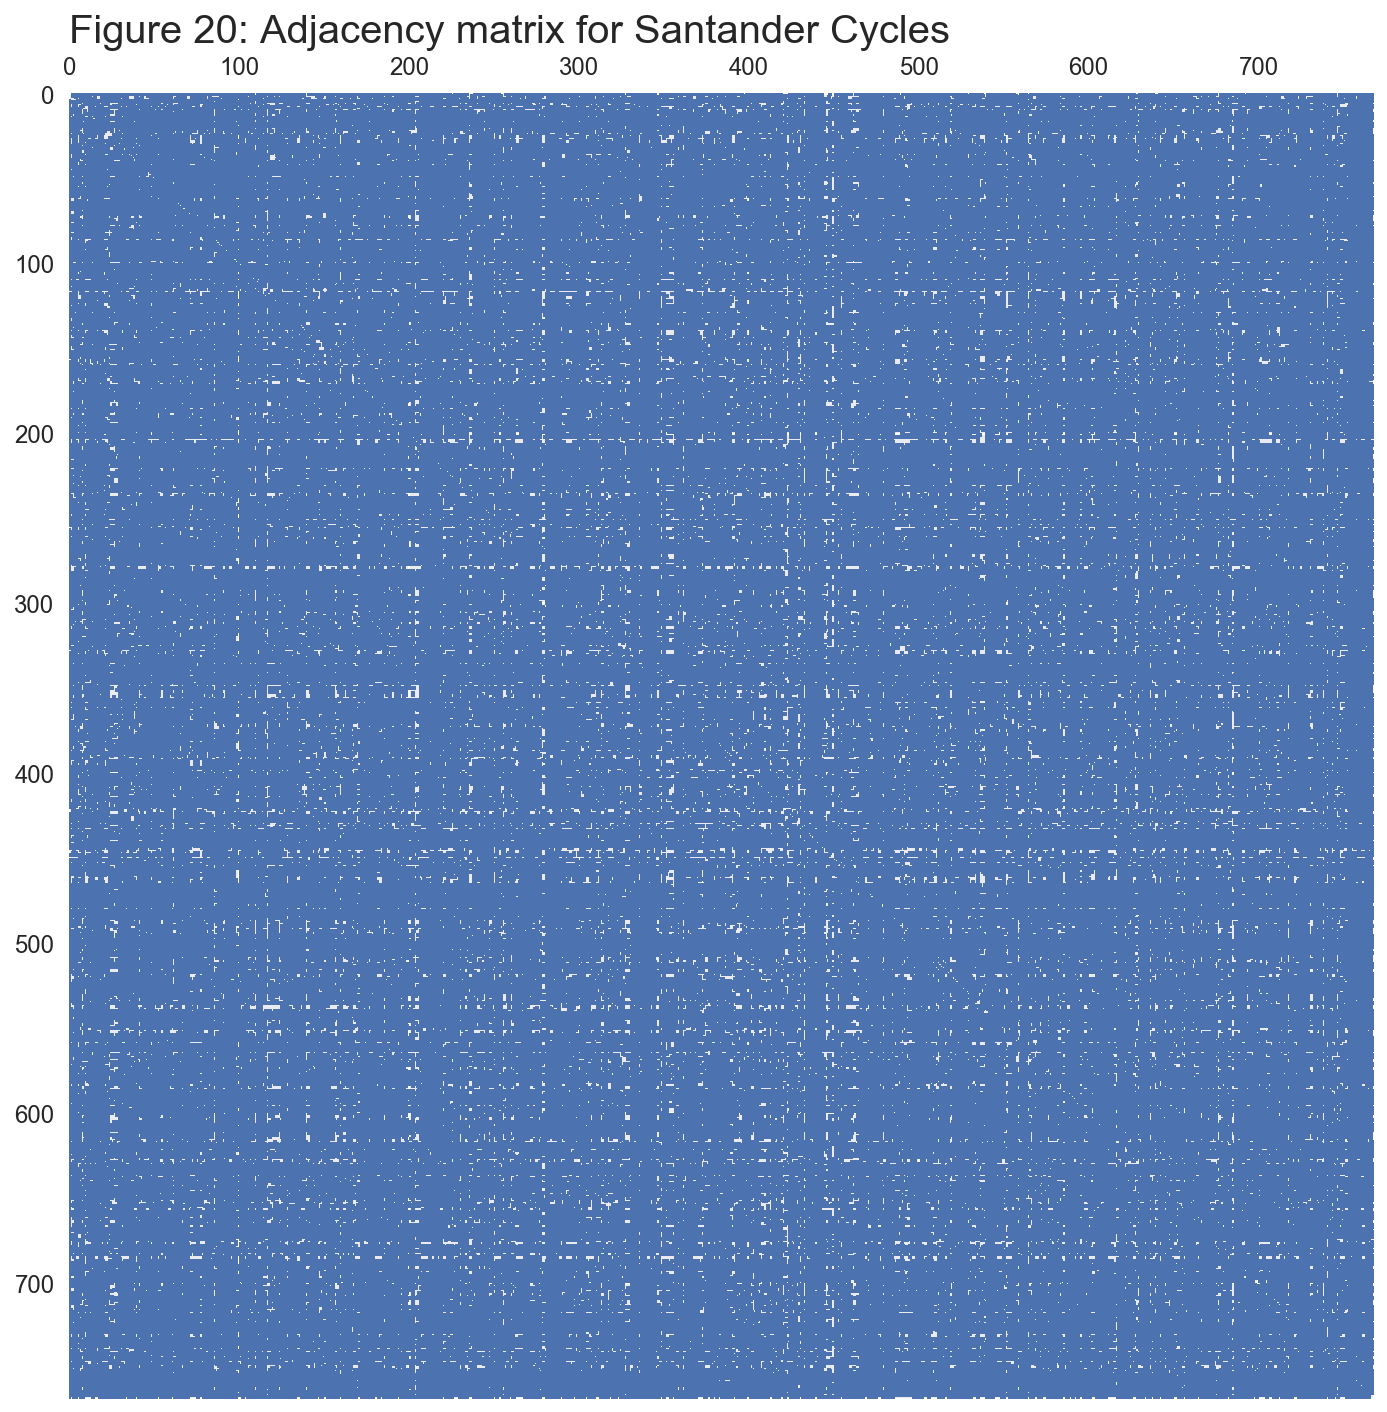

In [94]:
plt.figure(figsize=(12,12))
plt.spy(nx.adjacency_matrix(DG),markersize=2)
plt.xlabel('')
plt.ylabel('')
plt.title('Figure 20: Adjacency matrix for Santander Cycles', loc = 'left', fontsize = 20, y = 1.03)
plt.show()
# Suggests the vast majority of docking stations had at least 1 journey from one station
# to another, the order the nodes are displayed in could help to draw out information.
# Currently alphabetical based on docking station name.

Degree distribution displays the number of nodes with a given degree i.e. how many links the node has. In the context of the bike share scheme, this is looking at each station and analysing: 
1. Stations people have journeyed to from this dock (Out)
2. Stations people have arrived from at this dock (In) <br>

Both in- and out-degree are displayed on the histogram. The distribution for both are very similar. The average values for in- and out-degree are exactly the same as would be expected. The distribution peaks in the 400-500 degree bin for both in- and out-, displaying weakly negative skewness.

In [95]:
# Adding degree into dataframe:
degree = dict(nx.degree(DG))
degree_df = pd.DataFrame(degree.items())
degree_df.columns=['node','degree']
journeys['degree'] = degree_df['degree']

In [98]:
journeys.tail(5)

station  deficit      end        lat       lon  \
763    World's End Place, West Chelsea     41.0   9475.0  51.481805 -0.180274   
764  Wormwood Street, Liverpool Street  -4641.0  54119.0  51.516154 -0.082422   
765               Wren Street, Holborn   1853.0  18353.0  51.524564 -0.116279   
766          Wright's Lane, Kensington  -1361.0  22462.0  51.500397 -0.193068   
767           York Hall, Bethnal Green    549.0  15573.0  51.528936 -0.055894   

       start  num_docks size_dock  degree  
763   9516.0         22    Medium     904  
764  49478.0         16     Small    1362  
765  20206.0         33    Medium    1084  
766  21101.0         37    Medium    1070  
767  16122.0         27    Medium     876

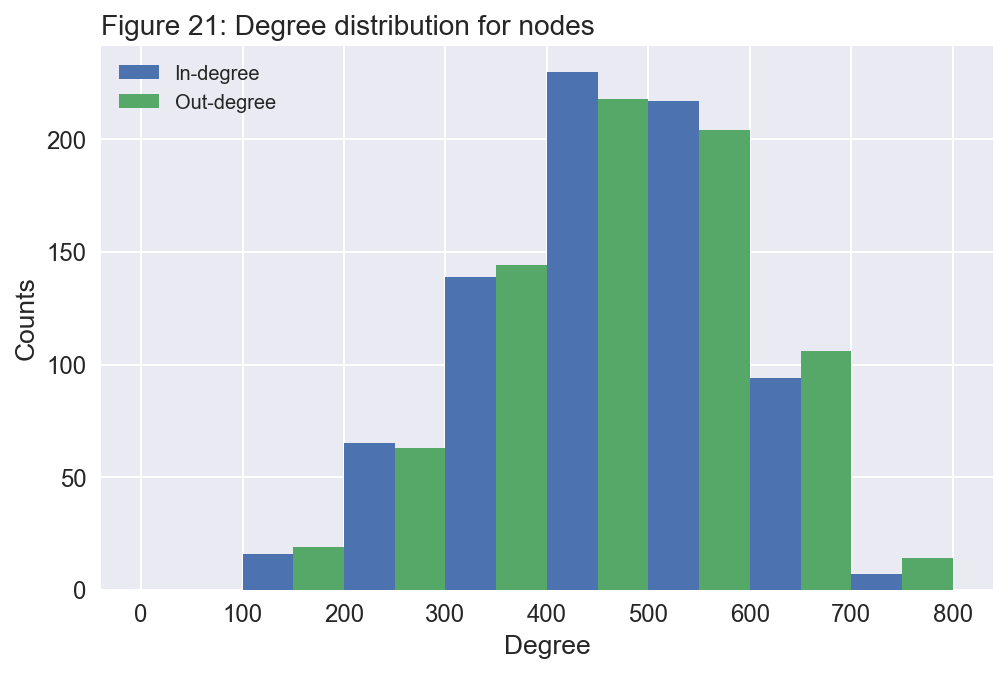

In [99]:
plt.hist([dict(DG.in_degree()).values(),dict(DG.out_degree()).values()], rwidth=1.5, stacked=False, bins=np.linspace(0,800,9))
plt.xlabel('Degree')
plt.ylabel('Counts')
plt.legend(['In-degree','Out-degree'],prop={'size': 10},
           loc='upper left')
plt.title('Figure 21: Degree distribution for nodes', loc = 'left', fontsize = 14)
plt.show()

#### Shortest path

If two nodes can be reached along a sequence of links, there is a path connecting them. The shortest one of them can be determined by starting at one of the nodes, and then checking if the other node is among the neighbours, second neighbours and so on until it is found. 

In [100]:
print nx.average_shortest_path_length(DG)

1.39419342134


#### Centrality Measures 

*Rankings of nodes or edges based on their importance to the network* 

Betweenness centrality for a node is equal to the number of shortest paths from all nodes to all others that pass through that node. For edge betweenness, it is a count of how many of these paths run through that link, this is slow to run for the dataset due to the number of edges.

Whitehall Place on the Strand is the highest ranked dock for betweeeness centrality, 5 of the other top 20 nodes for betweenness centrality are also on the Strand.<br>
<br>


In [101]:
node_centrality = nx.betweenness_centrality(DG)
edge_centrality = nx.edge_betweenness_centrality(DG)

In [102]:
nodes_df['betweenness'] = node_centrality.values()
sorted_btwn = nodes_df.sort_values('betweenness', ascending = False).head(10)

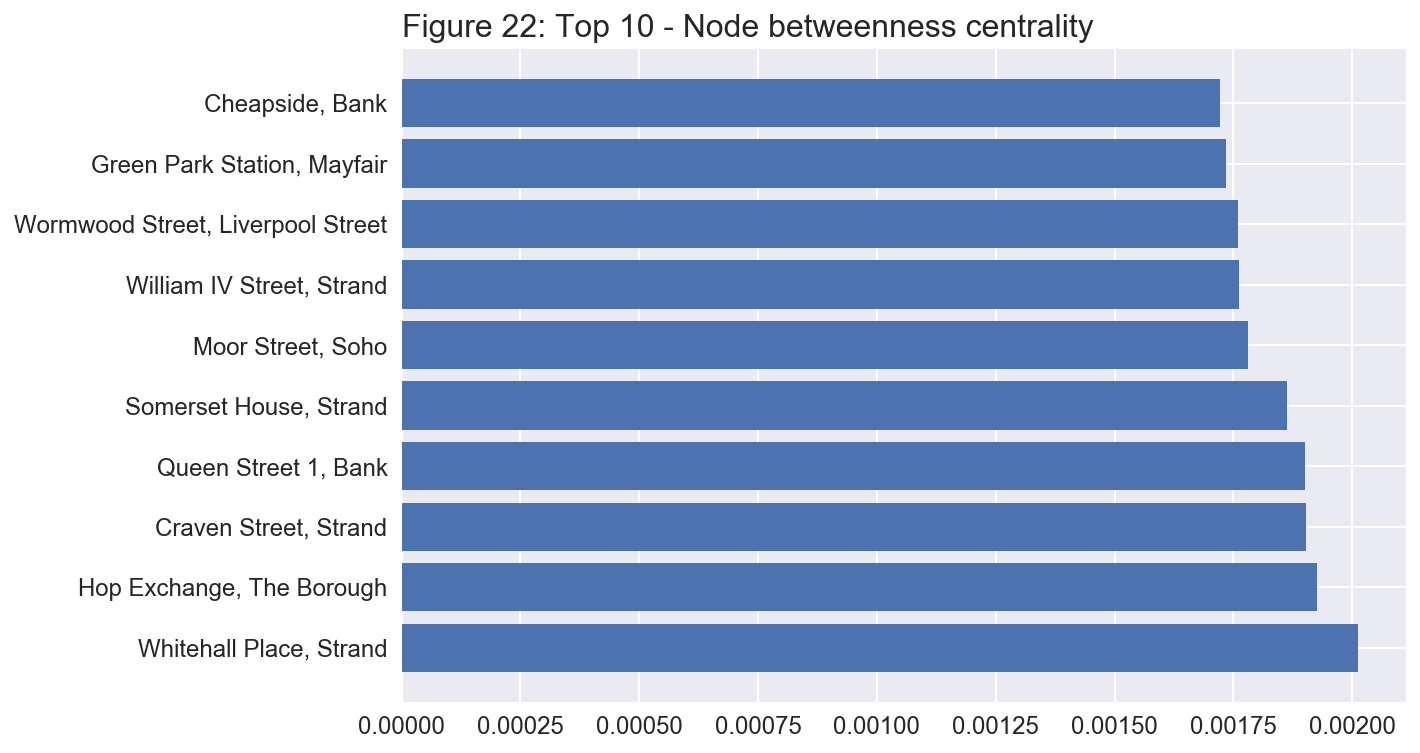

In [103]:
plt.figure(figsize = (9,6))
plt.barh(range(10),
         sorted_btwn.betweenness.values)
plt.yticks(range(10), sorted_btwn.station.values)
plt.title('Figure 22: Top 10 - Node betweenness centrality', loc = 'left', fontsize = 16)
plt.show()

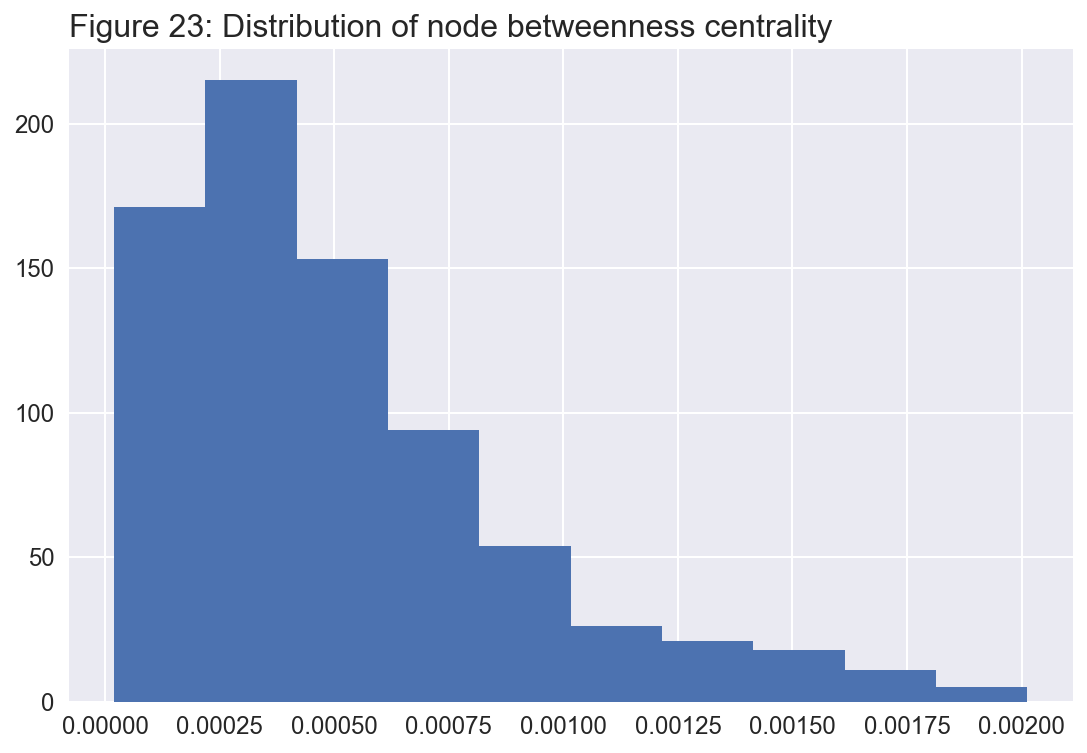

In [104]:
plt.figure(figsize = (9,6))
plt.hist(node_centrality.values())
plt.title('Figure 23: Distribution of node betweenness centrality', loc = 'left', fontsize = 16)
plt.show()

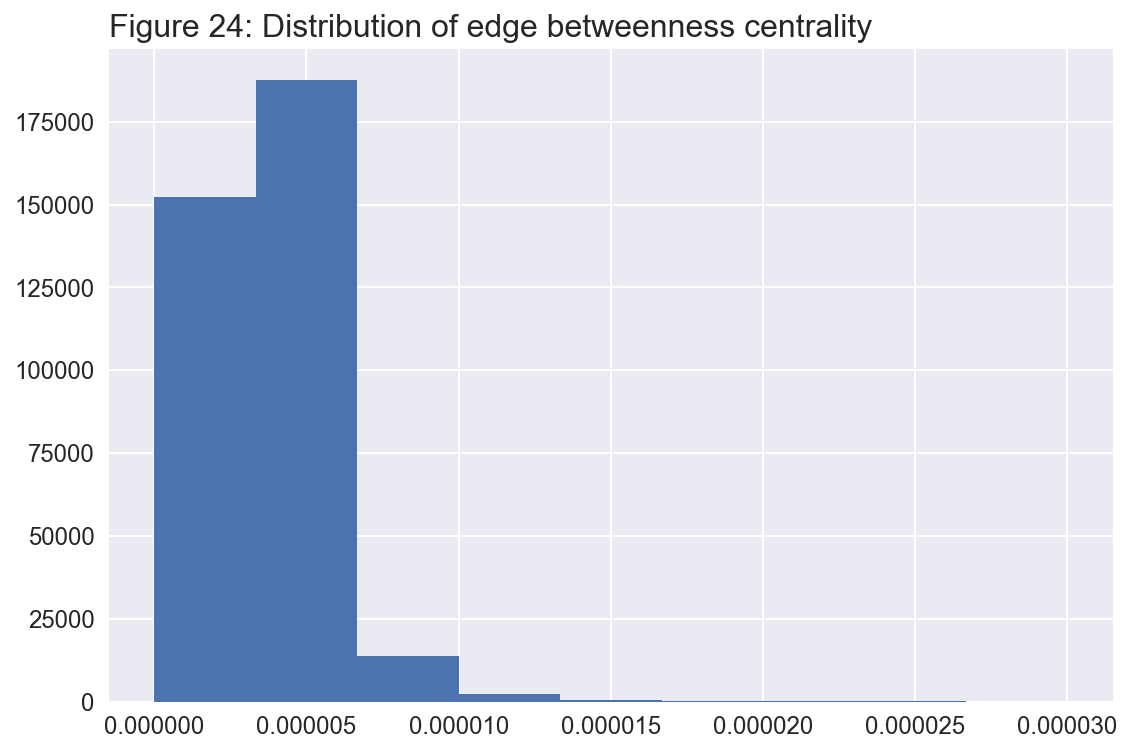

In [106]:
plt.figure(figsize = (9,6))
plt.hist(edge_centrality.values(), bins = np.linspace(0,0.00003,10))
plt.title('Figure 24: Distribution of edge betweenness centrality', loc = 'left', fontsize = 16)
plt.show()

#### Strongly Connected Components
A directed graph is strongly connected if there is a path between all pairs of nodes. 

All the nodes fall within a single strongly connected component.

In [107]:
scc = list(max(nx.strongly_connected_components(DG), key=len))

IN_component = [list(DG.predecessors(n)) for n in scc]
IN_component = sorted(list(set(np.unique(np.concatenate(IN_component))) - set(scc)))

OUT_component = [list(DG.successors(n)) for n in scc]
OUT_component = sorted(list(set(np.unique(np.concatenate(OUT_component))) - set(scc)))

In [108]:
print len(scc)
print len(IN_component)
print len(OUT_component)

768
0
0


#### Spearman Rank coeffficient

The in-degree and out-degree are both highly correlated with betweenness centrality.

In [109]:
spearmanr(dict(DG.in_degree()).values(),node_centrality.values())

SpearmanrResult(correlation=0.97702967614698022, pvalue=0.0)

In [110]:
spearmanr(dict(DG.out_degree()).values(),node_centrality.values())

SpearmanrResult(correlation=0.97148862888044241, pvalue=0.0)

#### PageRank
PageRank computes a ranking of the nodes in the graph DG based on the structure of the incoming links. It was originally designed as an algorithm to rank web pages - using links between pages as a measure of importance. 

In the context of this study, each docking station is assigned a score based upon its number of in-coming links. These links are also weighted depending on the relative score of its originating node. The result is that nodes with many in-coming links are influential, and nodes to which they are connected share some of that influence. 

The highest ranked node is Bell Lane, Liverpool Street followed by Watney Markey in Stepney Green, indicating both have many incoming links and that they are connected to nodes that also have many incoming links.


In [111]:
pagerank = nx.pagerank(DG, alpha=0.85, weight='weight')
pagerank_df = pd.DataFrame(pagerank.values(), index = pagerank.keys())
pagerank_df['station_name'] = nodes_df['station']
pagerank_df.rename(columns={0:'page_rank'},inplace=True) 
pagerank_sorted = pagerank_df.sort_values('page_rank', ascending = False).head(10)

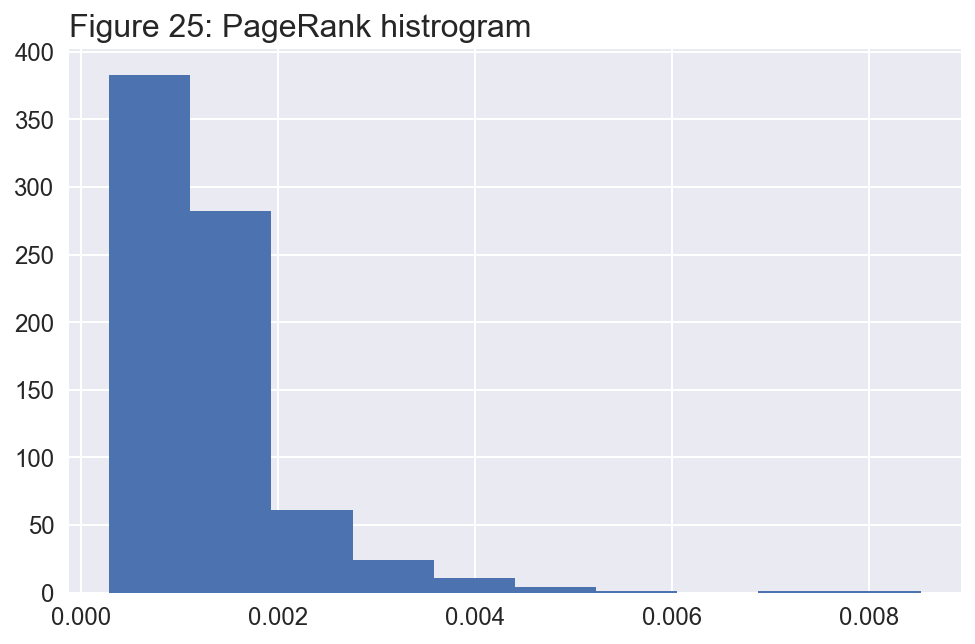

In [115]:
plt.hist(pagerank.values())
plt.title('Figure 25: PageRank histrogram', loc = 'left', fontsize = 16)
plt.show()

In [113]:
page_ranks = np.array(pagerank_sorted.page_rank)
rank_names = list(pagerank_sorted.station_name)

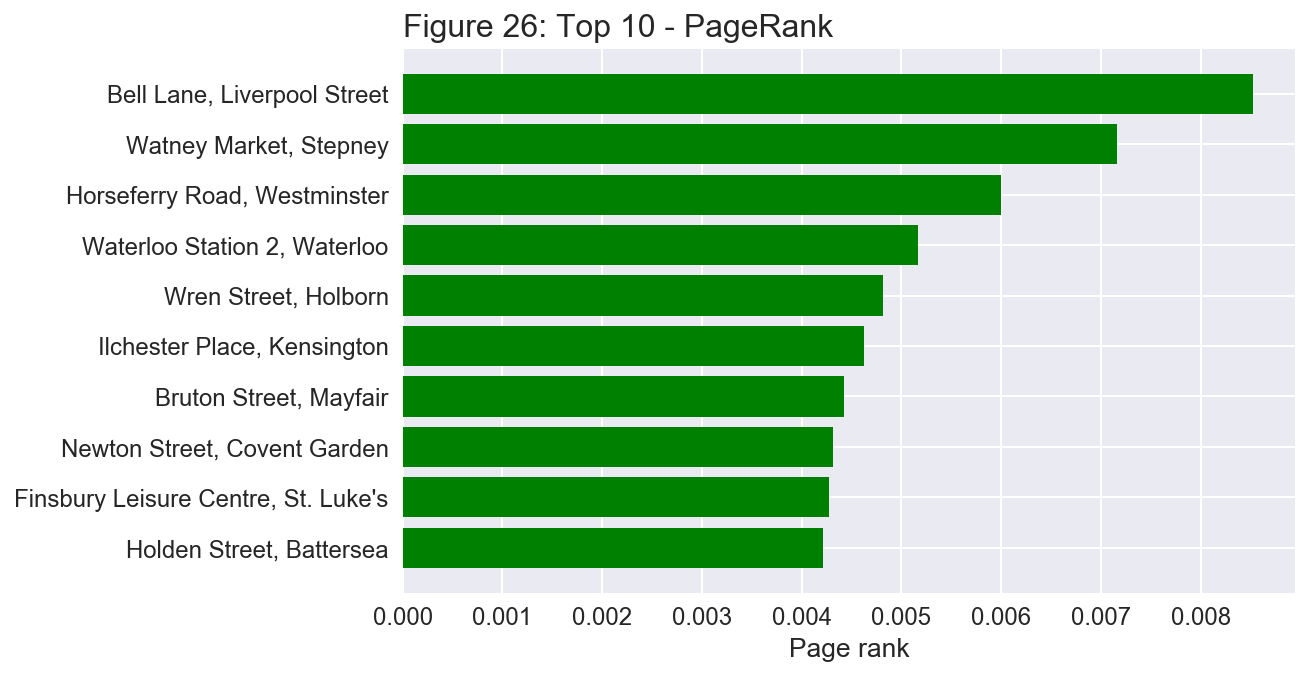

In [116]:
fig, ax = plt.subplots()
y_pos = np.arange(len(page_ranks))

ax.barh(y_pos, page_ranks, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(rank_names)
ax.invert_yaxis() 
ax.set_xlabel('Page rank')
ax.set_title('Figure 26: Top 10 - PageRank', loc = 'left', fontsize = 16)
plt.show()

#### Community Detection - Hierarchical/Agglomerative Clustering

*Identifying groups of nodes which are more closely related to each other than to other nodes in the network* 

The distance matrix is defined from the adjacency matrix by defining some similarity measure between the nodes. For example, **cosine similarity** can be calculated for each pair of row vector $x$ and column vector $y$ of the adjacency matrix obtaining:

$$\sigma_{ij} = \frac{x\cdot y}{\|x\|\|y\|}$$

In this context, it is high if two nodes share a large number of common neighbours. There are a variety of methods for calculating the distance between each newly formed cluster and all the other clusters:
* Average method: Proximity between two clusters is the arithmetic mean of all the proximities between the objects of one, on one side, and the objects of the other, on the other side. 
* Wards method: Proximity between two clusters is the magnitude by which the summed square in their joint cluster will be greater than the combined summed square in these two clusters.

The resulting dendogram can be used to obtain different numbers of communities by cutting it at different heights. 

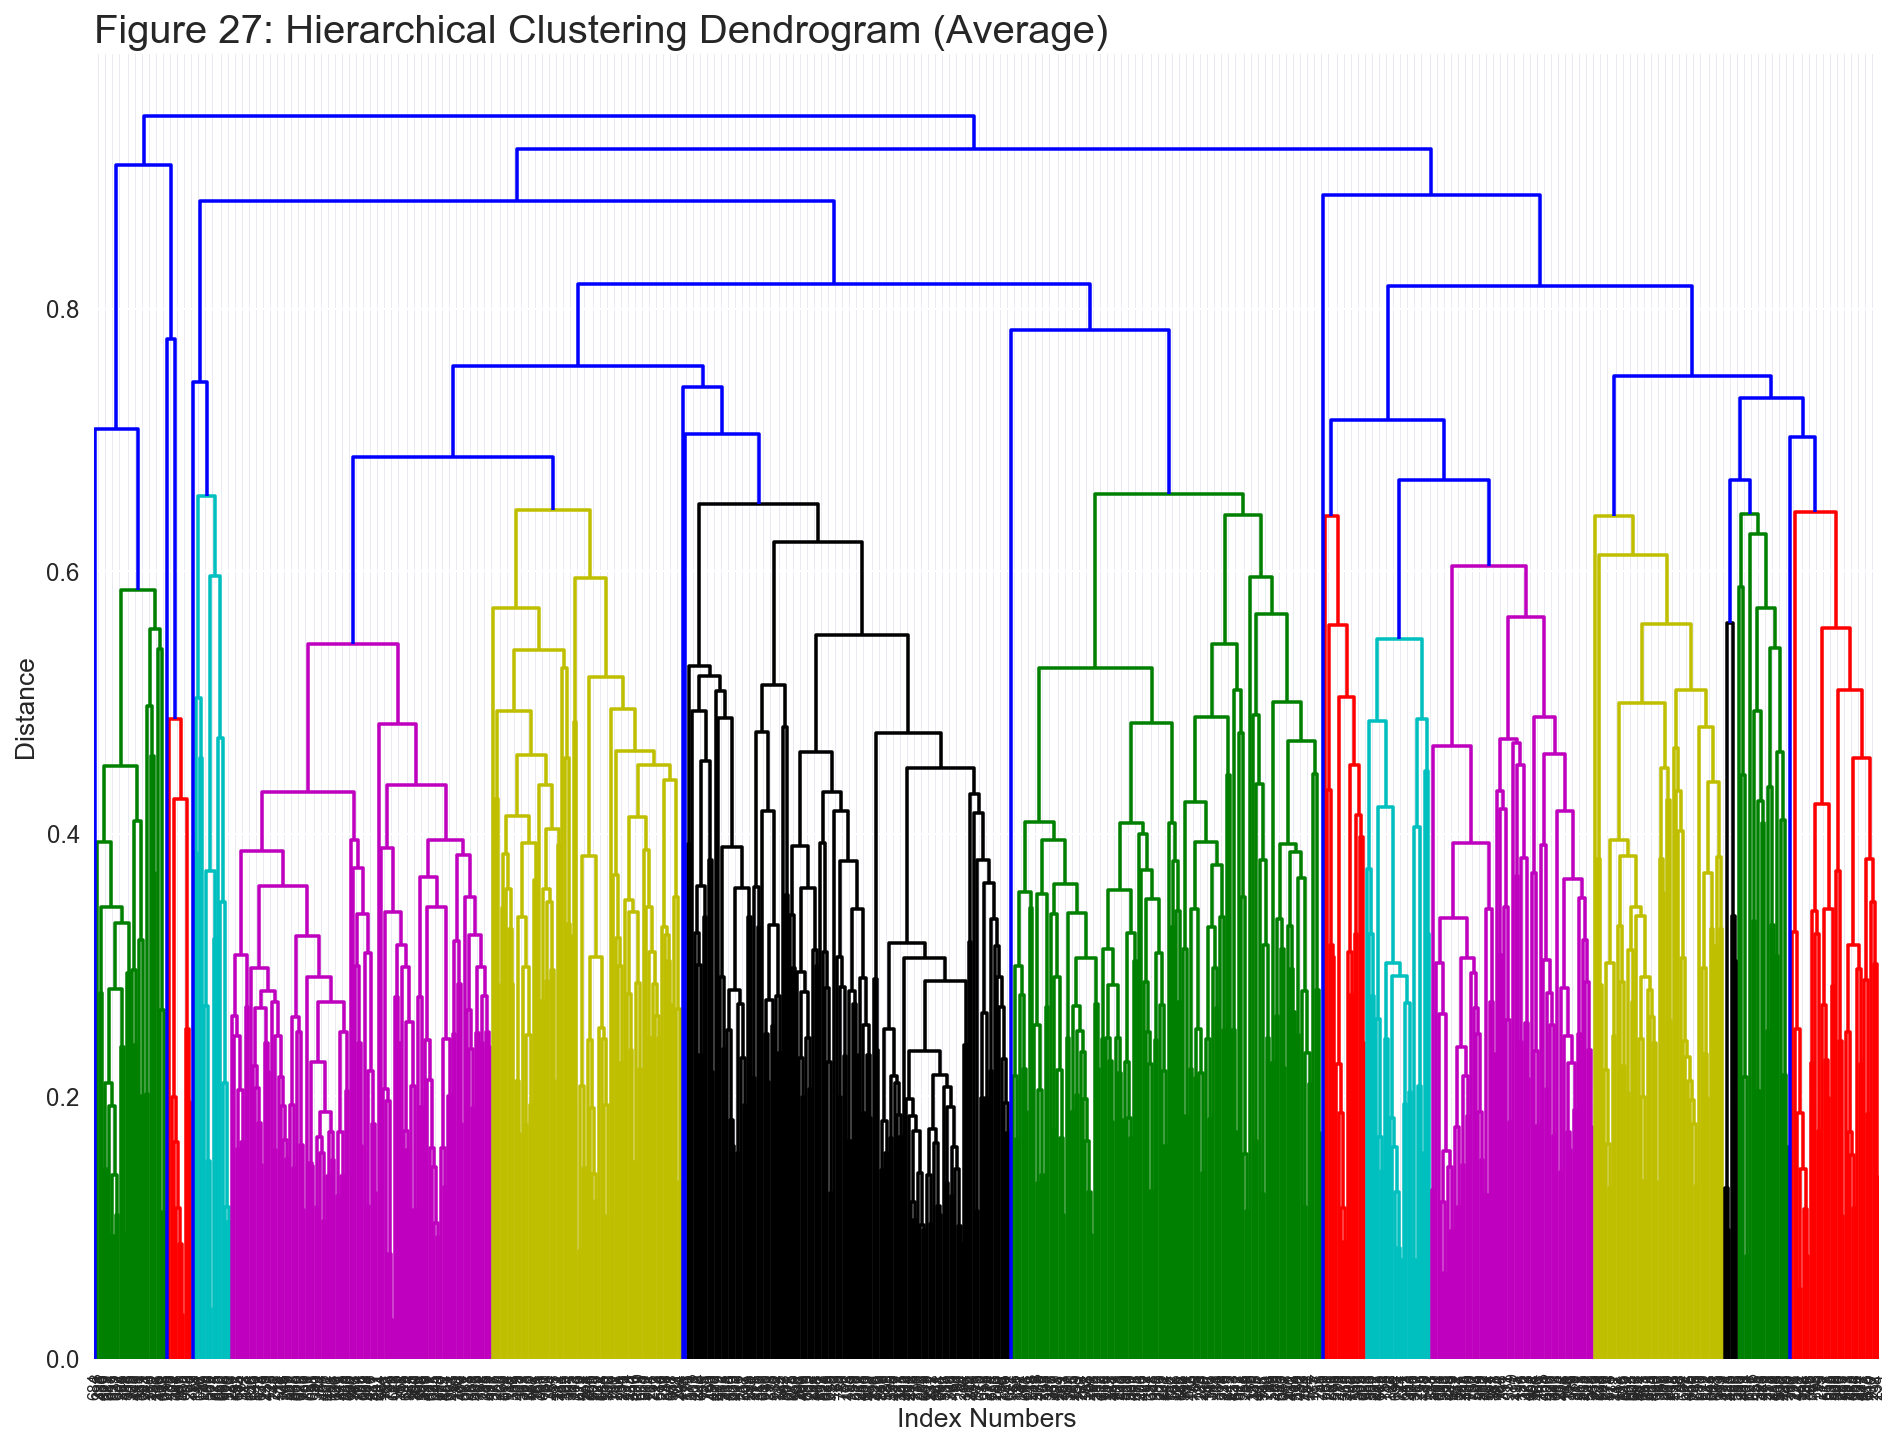

In [121]:
plt.figure(figsize = (16,12))
A = nx.adjacency_matrix(DG).toarray()
dist_out = pdist(A,metric='cosine')
Z = hierarchy.linkage(dist_out,method='average')
hierarchy.dendrogram(Z,leaf_rotation=90., leaf_font_size=8.)
plt.title('Figure 27: Hierarchical Clustering Dendrogram (Average)', loc = 'left', fontsize = 20)
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
plt.show()

In [118]:
def plot_clusters(max_dist):
    '''Runs clustering algorithm using distance criterion and create scatter plot of
    docks coloured by the assigned cluster'''
    # Run clustering algorithm with max_dist from function input
    clusters = fcluster(Z, max_dist, criterion='distance')
    # Create dictionary from cluster assignment and station names
    c_dict = dict(zip(nodes_df.station,clusters))
    sorted_key = sorted(c_dict.items(), key=operator.itemgetter(0))
    cluster_df = pd.DataFrame(sorted_key)
    journeys['cluster'] = cluster_df.iloc[:, 1]
    # Plot the cluster assignment geographically
    g = sns.lmplot( x='lon', y='lat', data=journeys, fit_reg=False, hue='cluster', legend=True)
    g.fig.set_size_inches(12,7)
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    plt.title('Hierarchical clusters from adjacency matrix, max_dist: %.2f' %(max_dist, ))
    plt.show() 


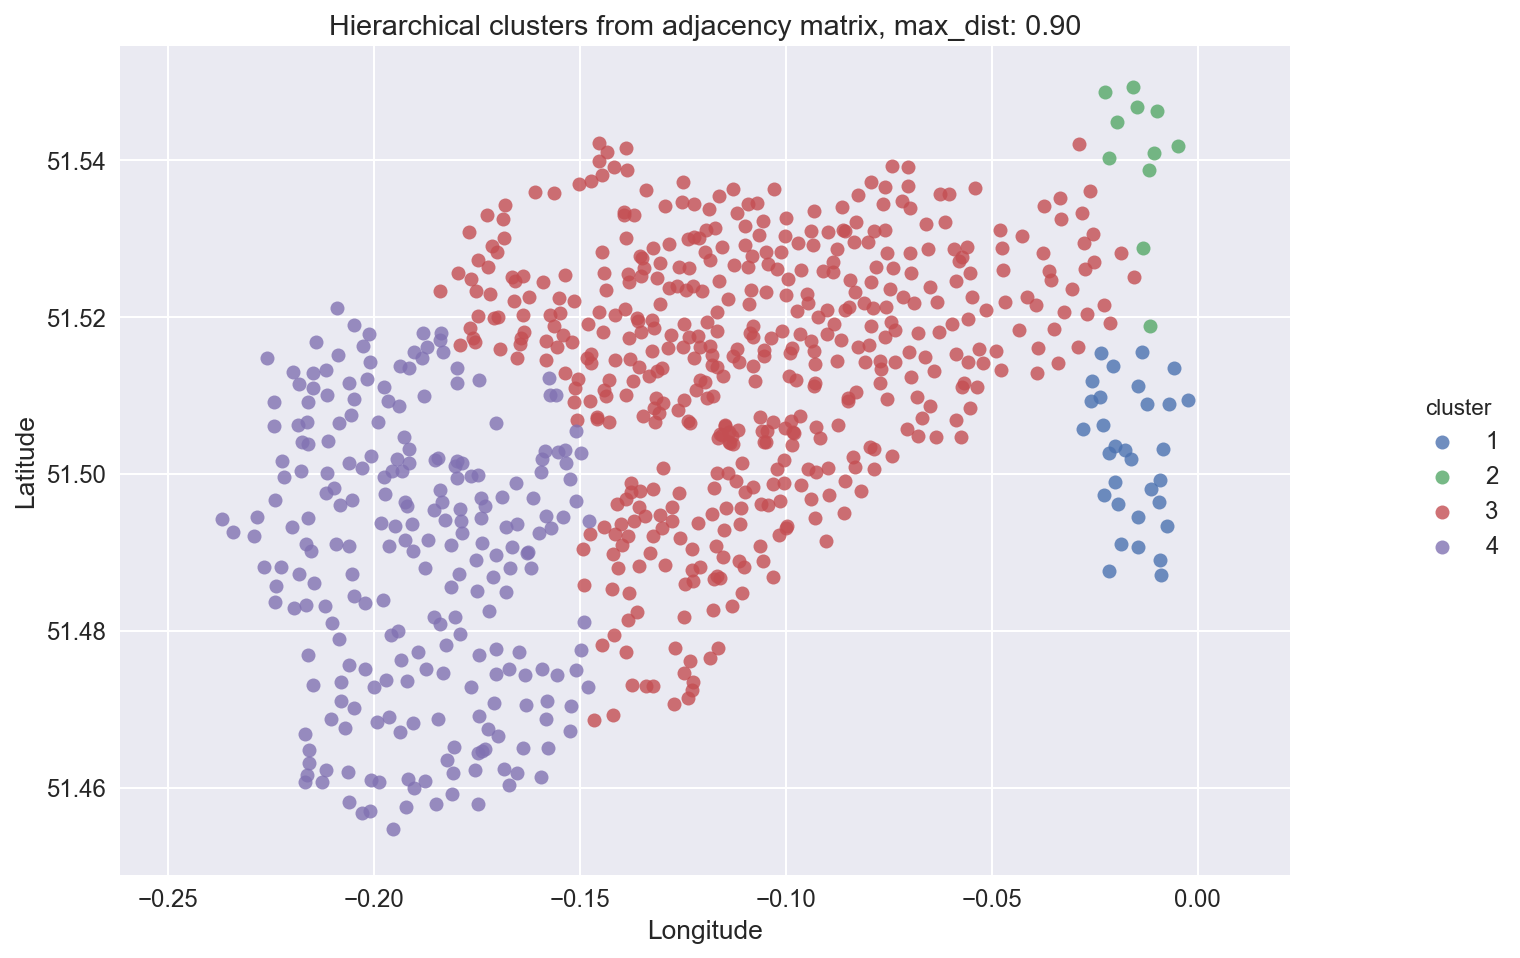

In [119]:
plot_clusters(0.9)

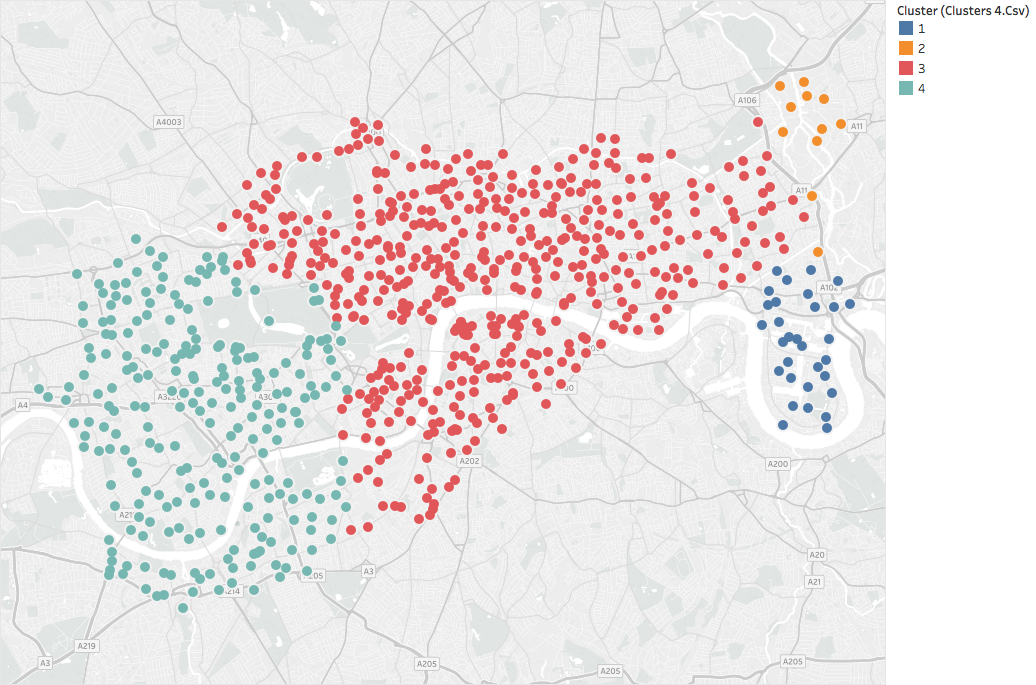

In [120]:
# A visual of the clusters created in Tableau with a background map included:
Image(filename='cluster_4.png')

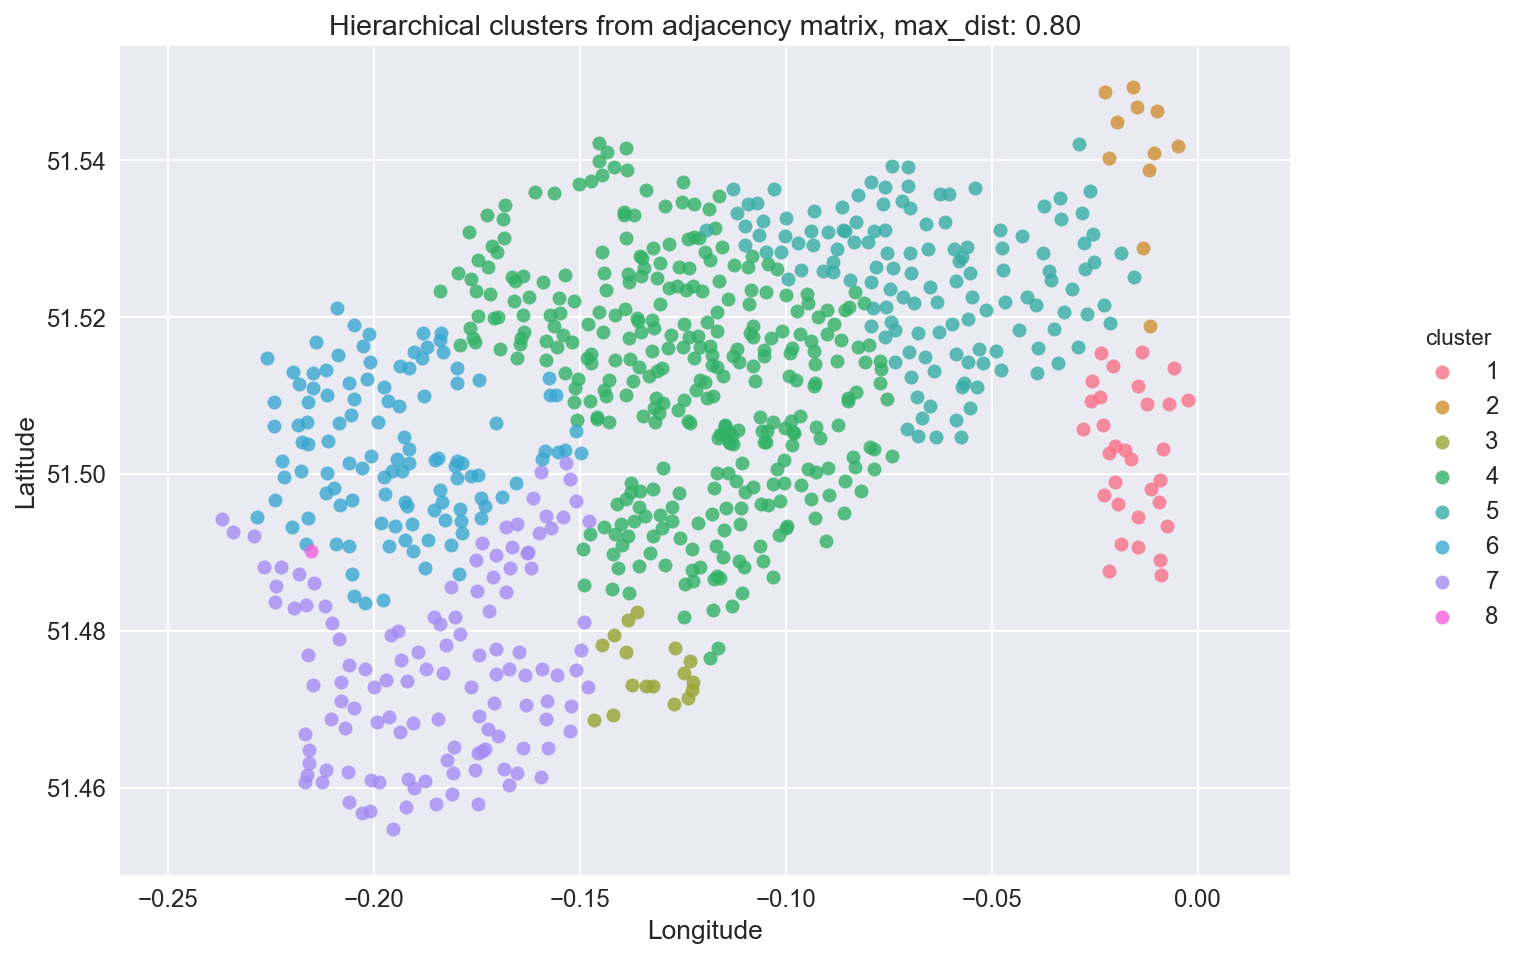

In [122]:
plot_clusters(0.8)

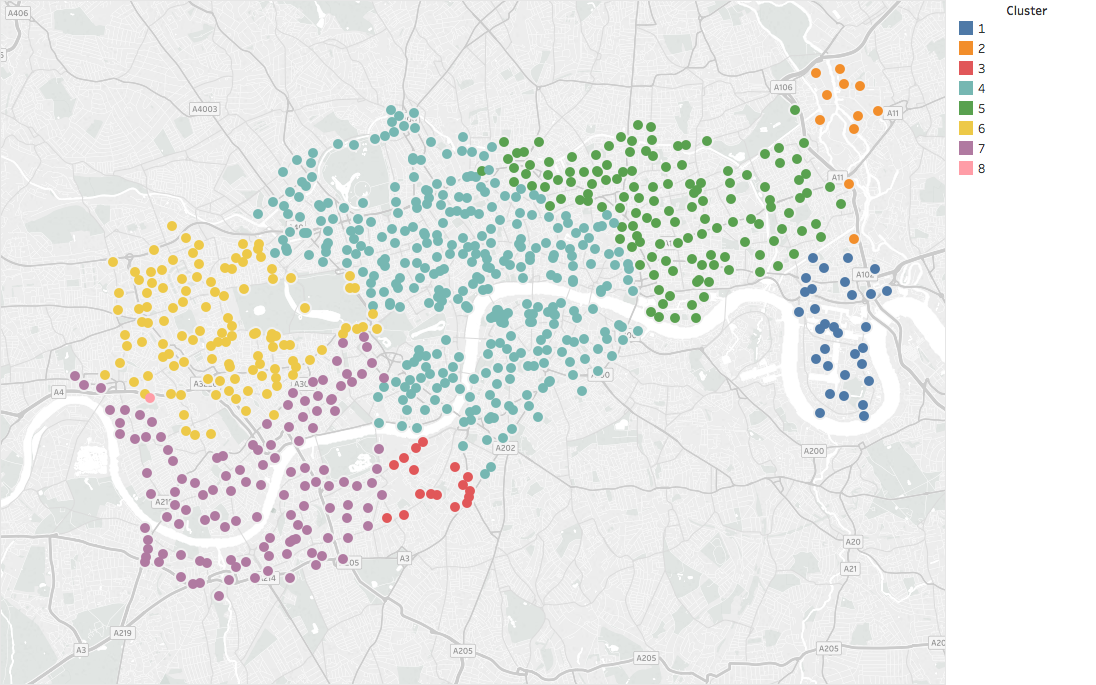

In [123]:
# Repeated for max_dist = 0.8, giving 8 clusters:
Image(filename='cluster_8.png')

Since cosine similarity is high if two nodes share a large number of common neighbours, the cluster patterns displayed on the graphs indicate docking stations which have a large number of journeys between them. 
* Slicing the dendogram at 0.9 yields 4 distinct communities, the largest (#3) covering the vast majority of central London with a separate distinct community to the west, and two to the east.
* Slicing the dendogram at 0.8 yields 8 distinct communities, the large central cluster is split into a western and eastern portion indicating more journeys are travelling north-south than east-west. However, the western cluster is split into a northern and a southern cluster, indicating more journeys are travelling east-west than north-south. Baron's Court is singled out in its own cluster. 
* Based on analysis using Tableau, this western divide does not appear to be caused by the River Thames. In fact, the clusters show no clear expression of the Thames acting as a barrier to connectivity at all. This might be due to the high level of bridges crossing the river in West London.

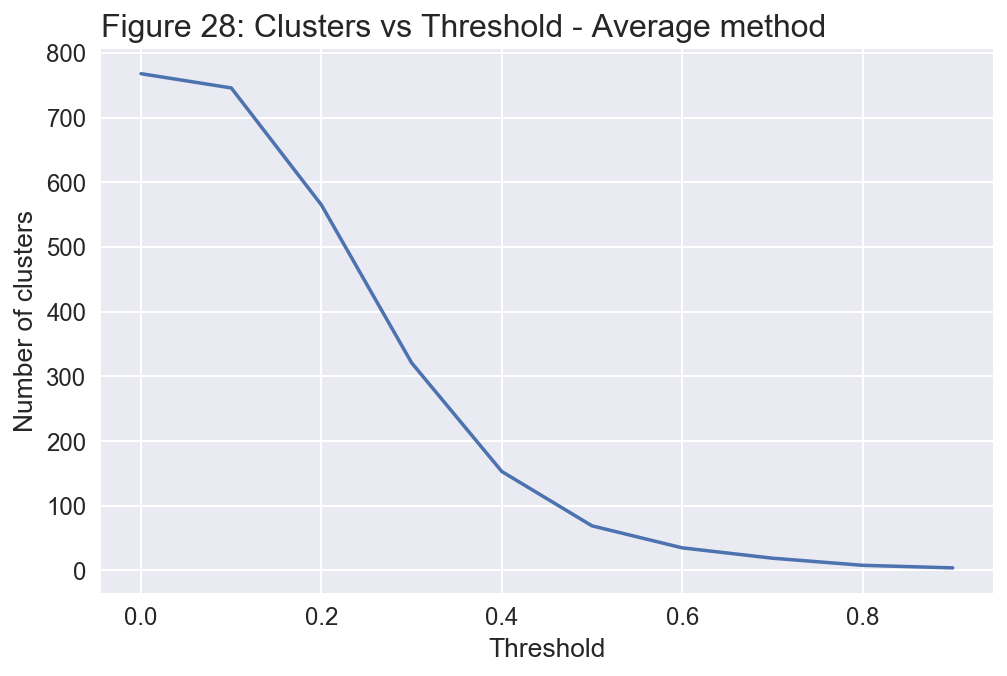

In [126]:
# Evaluate the number of clusters vs the threshold used graphically. There is a change in gradient in
# the line at around 0.5 - there are still c.70 clusters at this stage.
cluster_num = []
for max_d in np.arange(0,1,0.1):
    clusters = fcluster(Z, max_d, criterion='distance')
    cluster_num.append((max_d,len(set(clusters))))
    
plt.plot(np.array(cluster_num)[:,0],np.array(cluster_num)[:,1])
plt.xlabel('Threshold')
plt.ylabel('Number of clusters')
plt.title('Figure 28: Clusters vs Threshold - Average method', loc = 'left', fontsize = 16)
plt.show()

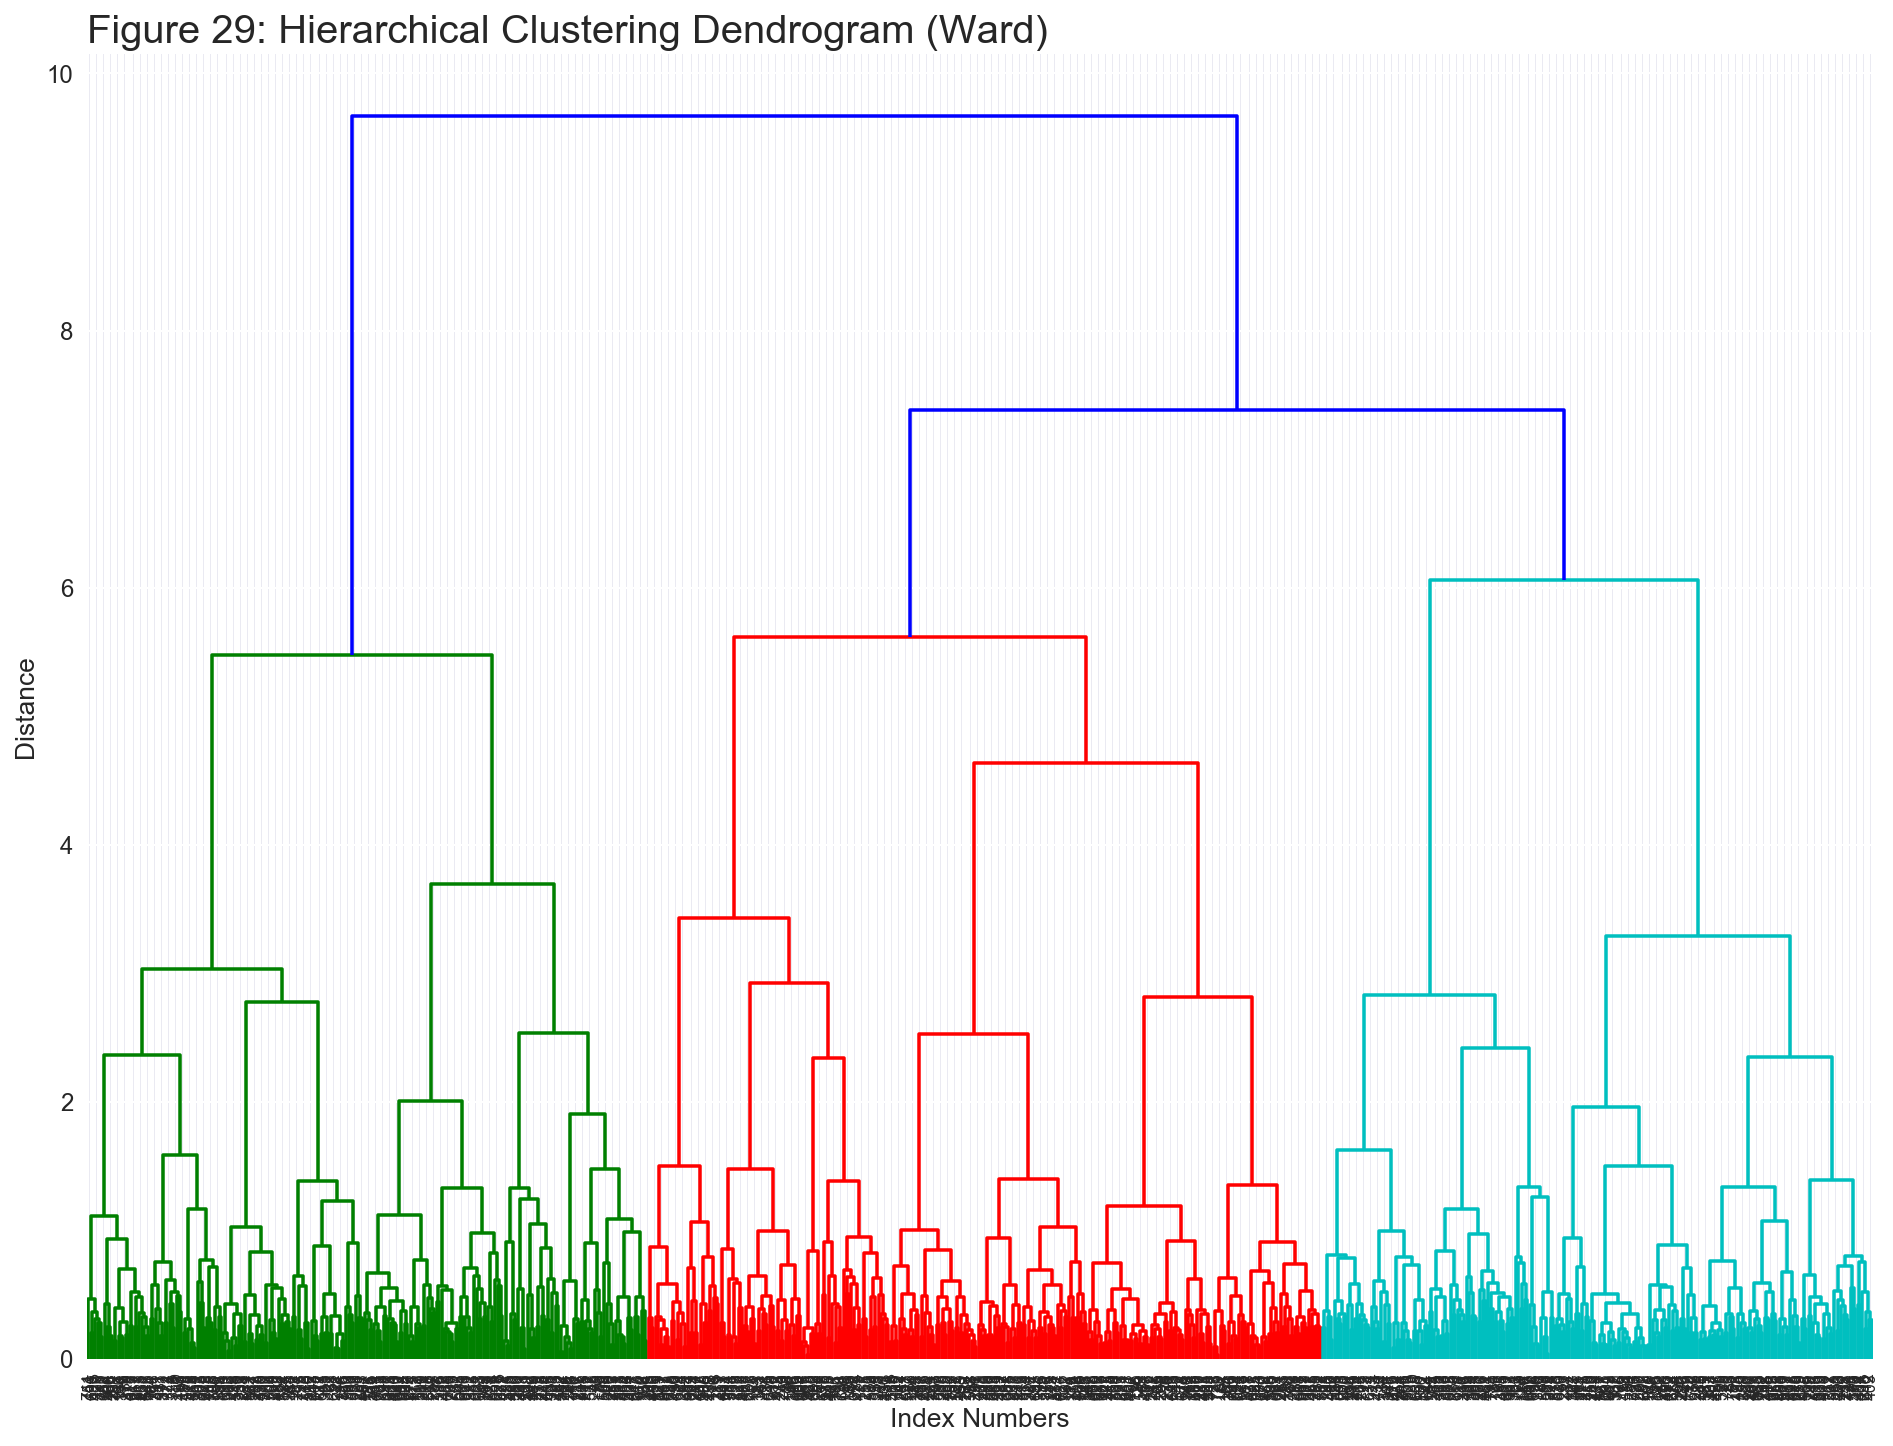

In [127]:
# Testing the Ward metric of similarity as an alternative
# Instead of using distance metrics, it analyses the variance
plt.figure(figsize = (16,12))
Z = hierarchy.linkage(dist_out,method='ward')
hierarchy.dendrogram(Z,leaf_rotation=90., leaf_font_size=8.)
plt.title('Figure 29: Hierarchical Clustering Dendrogram (Ward)', loc = 'left', fontsize = 20)
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
plt.show()

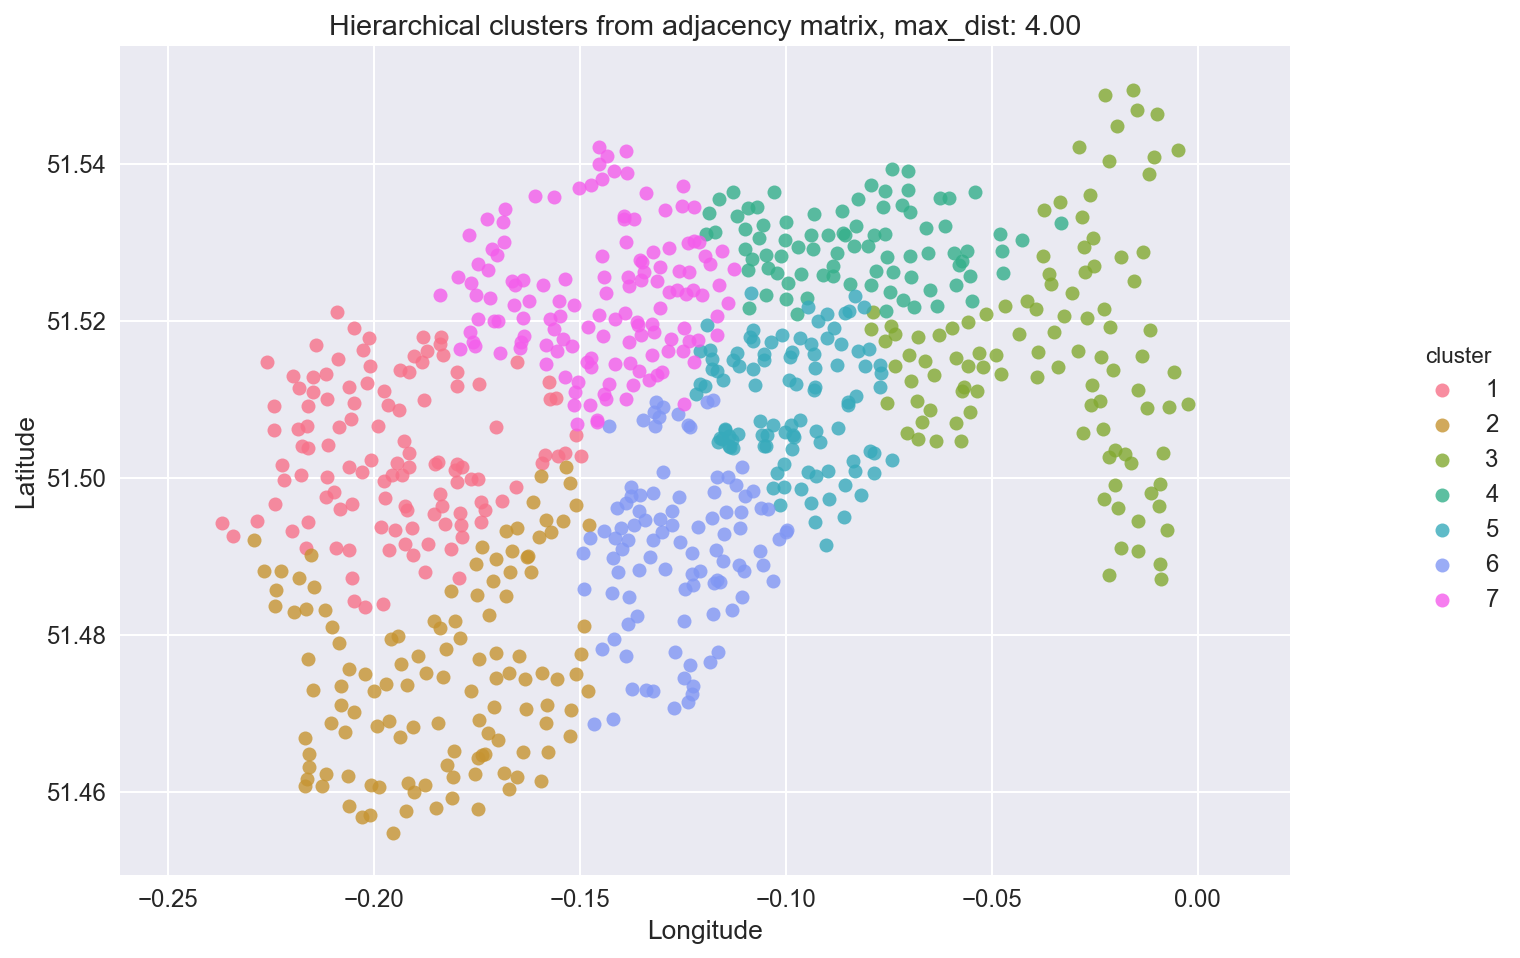

In [128]:
 plot_clusters(4)

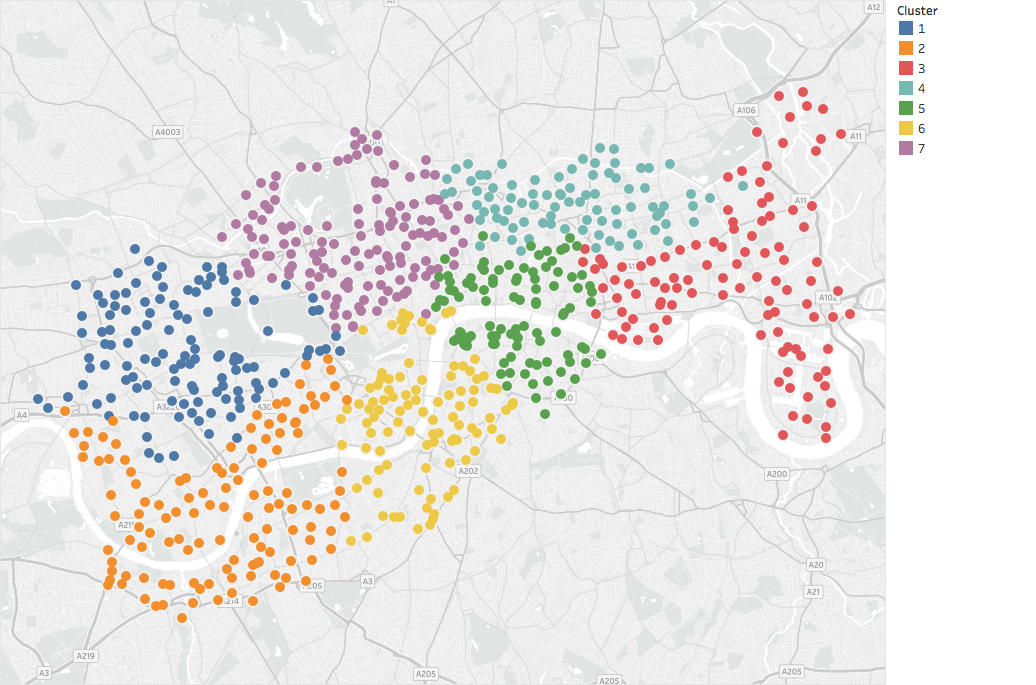

In [129]:
Image(filename='clusters_ward.png')

In [130]:
journeys.groupby('cluster').size()

cluster
1    119
2    122
3    104
4     85
5    101
6    100
7    137
dtype: int64

#### Summary - Network Analysis
* Directed graph has 768 nodes (docking stations) and 356854 edges (routes), weighted with number of journeys on that route. Directed means A-B and B-A are counted separately. 
* Average in degree and out degree is 464, indicating how many links the node has to other nodes. Weakly negative skewed distribution, indicating there are more nodes with fewer connections than there are nodes with higher connections. 
* When two nodes are connected by an edge, we say that they are adjacent. Adjacency matrix contains the number of journeys between each node and each other node. Difficult to interpret visually though its clear from the 'cross-hatch' pattern that some stations are VERY well connected.
* Betweenness centrality is equal to the number of shortest paths from all nodes to all others, that pass through that node. Whitehall Place, Strand comes top - in fact 3 of the top 5 docks are situated on the Strand, a main thoroughfare in central London.
* Edge betweenness centrality has a very narrow distribution, the majority of the edges have a similar edge betweenness centrality.
* PageRank ranks the nodes based on number of incoming edges and nodes to which they are connected also share some of that influence. The top 10 is quite a mixed bag of stations that have not ranked highly by any other measures (with the exception of Waterloo Station 2). These nodes are journeyed to from nodes which also receive journeys from a wide range of docks.
* Agglomerative clustering indicates that the river is not acting as a strong barrier to journeys, though it may well do if the scheme was introduced in the south east due to the lack of river crossings. Railway lines act as a baffle in at least one location. It indications journeys tend to follow a north-south direction in central London, and an east-west direction towards the suburbs. Using `ward` as the distance metric yields substantially different results when compared to `average` for a similar number of clusters. It results in more evenly sized clusters, with three covering central London rather than 1 large cluster.

### Future Work

* Acquire and incorporate redistribution data from Serco or TFL.
* Build a classification based model to predict whether a docking spot will be free when arriving at a dock e.g. 'Spaces' or 'Full'. A step further than this, would be to then perform a distance calculation and repeat the process for the next nearest dock until one with 'Spaces' is found.
* Develop a Flask app to host the outputs from this model.

### Production Considerations

* Hire data is made available in chunks of two week data which would need to be constantly  incorporated and the model retrained. Certain predictors are intrinsically variable such as the weather but others tend not to change such as distribution of public holidays through the year. There are also external factors which are not currently taken into account, such as the rise of dockless bike schemes in London, which may take trade away from the Santander Cycles scheme.
* The model could be deployed within a Flask app to provide an on the day indication of how busy the network is likely to be based on the forecasted weather, obtained via the WorldWeather Online API, plus predefined considerations such as day of the week, whether it's a public holiday and the total number of docks currently active across the network via the TFL API. 
* Provide the baseline value for the model and also the current model accuracy using Median Absolute Error to give an indication of the model accuracy.
* Use inexpensive Cloud-based data storage such as Amazon's S3 to store the input data, and an AWS EC2 instance to deploy the app.
* To tie in with possible future work, a useful addition to the app would be the ability to input a date and time of travel, plus a destination station then predict whether there would be availability by the time of arrival.